# Project Tumor Trace: MRI-Based AI for Breast Cancer Detection

## Business Understanding

- **Objective:** The Tumor Trace project aims to develop an AI-based model for detecting breast cancer using MRI images.
- **Project Goals:**

> By leveraging deep learning techniques, the goal is to provide accurate predictions to assist radiologists in early diagnosis.


## Data Understanding

### Loading the dataset

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2


# Define the path to your dataset
data_dir = r"/kaggle/input/tumor-trace-dataset"

# Check the directory structure
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Print the classes available in the train directory
print("Classes in training set:")
print(os.listdir(train_dir))

print("\nClasses in val set:")
print(os.listdir(val_dir))

print("\nClasses in test set:")
print(os.listdir(test_dir))

Classes in training set:
['Benign', 'Malignant']

Classes in val set:
['Benign', 'Malignant']

Classes in test set:
['Benign', 'Malignant']


### Anaylzing the dataset

#### Counting images in each class directory

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

def count_images(directory):
   
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Count images in the training set
train_class_counts = count_images(train_dir)
print("Number of images in each class (train):", train_class_counts)


Number of images in each class (train): {'Benign': 61, 'Malignant': 105}


#### Displaying sample images from a given directory

Sample images from the 'Benign' class


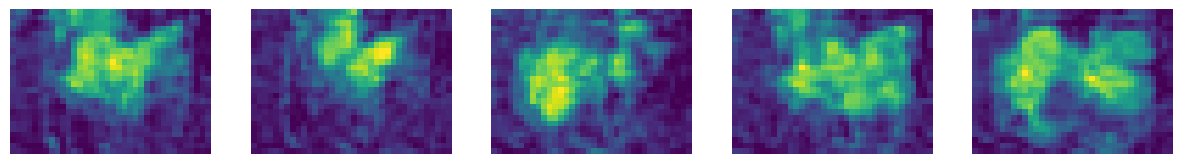

Sample images from the 'Malignant' class


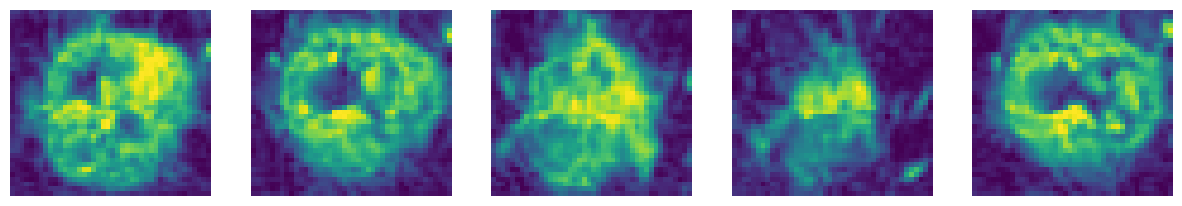

In [3]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Displayingg sample images from a given directory
def show_sample_images(class_dir, num_images=5):
    
    class_images = os.listdir(class_dir)[:num_images]
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(class_images):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()


# Defining the train\Benign\BreaDM-Be-1801 directory 
benign_images = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1801"
img_dir = os.path.join(benign_images, 'SUB1')

malignant_images = r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1802"
img_dir = os.path.join(benign_images, 'SUB2')

# Showing sample images from the 'Benign' class
print("Sample images from the 'Benign' class")
show_sample_images(os.path.join(benign_images, 'SUB1'))


# Showing sample images from the 'Maligant' class
print("Sample images from the 'Malignant' class")
show_sample_images(os.path.join(malignant_images, 'SUB2'))




## Data Preparation


### Data Transformation

In [4]:
import torchvision.transforms as transforms
import torch

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224 pixels
    transforms.ToTensor(),  # Converting to PyTorch tensor
    # Normalization- process of scaling pixel intensity values to a common range
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values
])


#### Visualizing the transform img

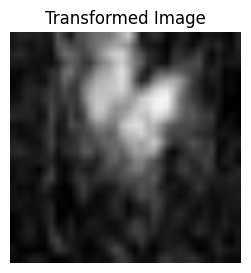

In [5]:
# Function to visualize the transformed image
def show_transformed_image(img_path):
    # Open the image
    image = Image.open(img_path)

    # Convert the image to RGB if it’s in a different mode
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    # Apply the transformations
    transformed_image = transform(image)
    
    # Convert back to numpy for visualization
    img = transformed_image.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    
    # Unnormalize the image for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)  # Clamp the values to [0, 1]

    # Plot the image
    plt.figure(figsize=(4, 3))
    plt.imshow(img)
    plt.title("Transformed Image")
    plt.axis('off')
    plt.show()

# Example image 
example_image_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1801/SUB1/p-032.jpg"
show_transformed_image(example_image_path)

### Data Augmentation

In [6]:
# Define data augmentation with additional techniques
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),  # Random rotation
    transforms.RandomCrop(224, padding=4),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Random color jitter
    transforms.RandomGrayscale(p=0.1),  # Randomly convert image to grayscale with a probability of 0.1
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),  # Random perspective transformation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Visualizing the Augmentated image

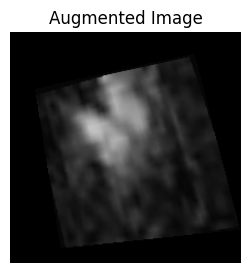

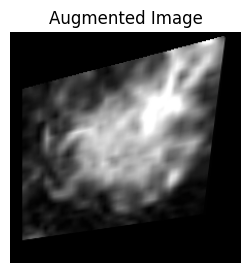

In [8]:
# Function to visualize the augmented image
def show_augmented_image(img_path):
    # Open the image
    image = Image.open(img_path)

    # Converting the image to RGB if it’s in a different mode
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Applying the augmentation transformations
    augmented_image = train_transform(image)

    # Convert back to numpy for visualization
    img = augmented_image.permute(1, 2, 0)  # Change from (Channels, Height, Width) to (Height, Width, Channels)

    # Unnormalize the image for visualization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    img = img.clamp(0, 1)  # Clamp the values to [0, 1]

    # Plot the image
    plt.figure(figsize=(4, 3))
    plt.imshow(img)
    plt.title("Augmented Image")
    plt.axis('off')
    plt.show()

# Example image paths for Benign and Malignant classes
benign_example_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1801/SUB1/p-032.jpg"
malignant_example_path = r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1802/SUB2/p-035.jpg"

# Show augmented images
show_augmented_image(benign_example_path)
show_augmented_image(malignant_example_path)

### Setting up dataloaders

#### Creating Dataset with updated transformation

In [9]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

data_dir = "/kaggle/input/tumor-trace-dataset"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=test_transform)

#### Creating DataLoader

In [10]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

# Check the size of each dataset
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


Training set size: 20434
Validation set size: 1989
Test set size: 6851


#### Example of Data transformation on single img

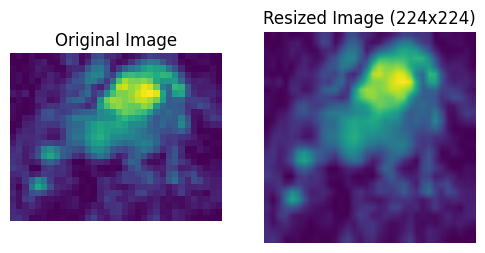

In [11]:
# Definingg the path to your image
img_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1805/SUB2/p-033.jpg" 

# Load the image
image = Image.open(img_path)

# Defining the transformation
resize_transform = transforms.Resize((224, 224))

# Apply the transformation
resized_image = resize_transform(image)

# Visualizingg the original and resized images
plt.figure(figsize=(6, 4))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Resized Image (224x224)')
plt.imshow(resized_image)
plt.axis('off')

plt.show() 

## Feature Extraction technique

## Histogram of Oriented Gradients (HOG)

- HOG is a feature descriptor in computer vision that is widely used for object detection.

- captures appearance and shape information of an object by counting the occurrences of gradient orientations in localized regions of an image.

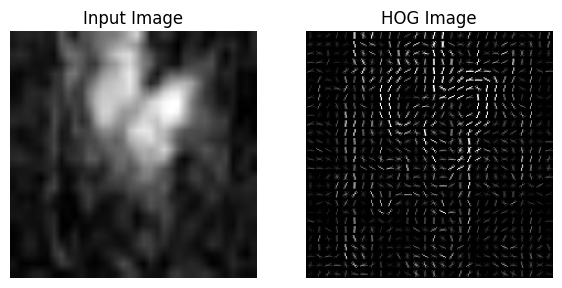

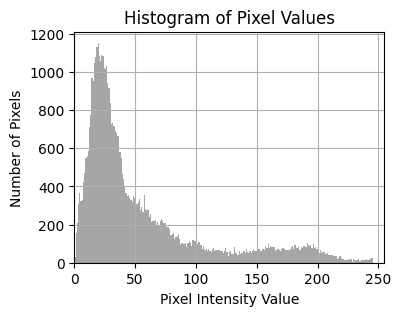

In [12]:
import cv2
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

# Load the image
image_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1801/SUB1/p-032.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resizing the image to 224x224
resized_image = cv2.resize(image, (224, 224))

hog_features, hog_image = hog(
    resized_image, 
    pixels_per_cell=(8, 8), 
    cells_per_block=(2, 2), 
    visualize=True, 
    feature_vector=True, 
    block_norm='L2-Hys'
)
pixel_values = resized_image.flatten()

# Rescaling histogram 
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# Display the HOG image
plt.figure(figsize=(7, 8))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Input Image')
plt.imshow(resized_image, cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('HOG Image')
plt.imshow(hog_image_rescaled, cmap='gray')

plt.figure(figsize=(4, 3))
plt.hist(pixel_values, bins=256, range=(0, 256), color='gray', alpha=0.7)
plt.title('Histogram of Pixel Values')
plt.xlabel('Pixel Intensity Value')
plt.ylabel('Number of Pixels')
plt.xlim(0, 255)  # For 8-bit grayscale images
plt.grid()


plt.show()


## Sobel Operator
- Operator is used to find the edges in an image by specifying regions where there is a significant change in intensity (brightness).
- It works by calculating the gradient (rate of change) of the image intensity at each pixel.


In [13]:
import numpy as np

# 3x3 matrix representing a simple image.
image = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

# 2x2 matrix used for convolution,helpingg to detect patterns in the image.
kernel = np.array([
    [1, 0],
    [0, -1]
])

# Function to perform convolution on the input image with the given kernel.
def convolve(image, kernel):
    image_x, image_y = image.shape # dimensions (height and width) of the image.
    kernel_x, kernel_y = kernel.shape # dimensions of the kernel

    # Kernel radius
    height_radius, width_radius = np.array(kernel.shape) // 2
    
    # Determine the output dimensions
    stride = 1
    padding = 0
    output_x = int(((image_x - kernel_x + 2 * padding) // stride) + 1) 
    output_y = int(((image_y - kernel_y + 2 * padding) // stride) + 1)
    print("\nOutput x dimension:", output_x)
    print("Output y dimension:", output_y)
    
    # Initialize the output feature map
    output = np.zeros((output_x, output_y))
    
    # Perform convolution
    for i in range(output_x):
        for j in range(output_y):
            region = image[i:i + kernel_x, j:j + kernel_y]
            output[i, j] = np.sum(region * kernel)
    
    return output

# Perform convolution
convolved_image = convolve(image, kernel)
print("\nConvolved Image:\n", convolved_image)

# Eg Sobel X operator detecting horizontal edges.
Sobel_x_operator = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

# Perform convolution with Sobel operator
sobel_convolved_image = convolve(image, Sobel_x_operator)
print("\nSobel X Convolved Image:\n", sobel_convolved_image)



Output x dimension: 2
Output y dimension: 2

Convolved Image:
 [[-4. -4.]
 [-4. -4.]]

Output x dimension: 1
Output y dimension: 1

Sobel X Convolved Image:
 [[8.]]


[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]


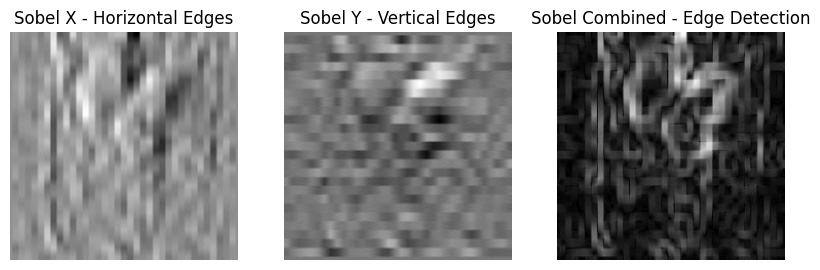

In [14]:
 import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to perform convolution
def convolve(image, kernel):
    image_x, image_y = image.shape   # dimensions (height and width) of the image.
    kernel_x, kernel_y = kernel.shape # dimensions of the kernel
    print(kernel)

    # Determining the output dimensions
    stride = 1 # step size by which we move the kernel across the image (set to 1 here).
    padding = 0
    output_x = int(((image_x - kernel_x + 2 * padding) // stride) + 1) # dimensions of the output image after applying the kernel. #1
    output_y = int(((image_y - kernel_y + 2 * padding) // stride) + 1) # dimensions of the output image after applying the kernel.#1
    
    # Initialize the output feature map
    output = np.zeros((output_x, output_y)) # matrix initialized to zeros to store the convolution result.
    #initialized to zeros to ensure it starts with a clean slate.

    # Perform convolution in that we  move the kernel over the image.
    for i in range(output_x):
        for j in range(output_y):
            region = image[i:i + kernel_x, j:j + kernel_y]
            output[i, j] = np.sum(region * kernel)

    return output

# Sobel X operator (horizontal edges)
sobel_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

# Sobel Y operator (vertical edges)
sobel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

# Load the image and convert to grayscale
image = resized_image

image = np.array(image)
# Converting the Image to a Numpy Array:

# Apply Sobel X operator
sobel_x_image = convolve(image, sobel_x)

# Apply Sobel Y operator
sobel_y_image = convolve(image, sobel_y)

# Calculate the magnitude of gradients
sobel_combined = np.sqrt(sobel_x_image**2 + sobel_y_image**2)

# Plot the results
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sobel_x_image, cmap='gray')
plt.title('Sobel X - Horizontal Edges')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sobel_y_image, cmap='gray')
plt.title('Sobel Y - Vertical Edges')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel Combined - Edge Detection')
plt.axis('off')

plt.show()


## Local Binary Pattern
Local Binary Pattern (LBP) is a simple yet very efficient texture operator which labels the pixels of an image by thresholding the neighborhood of each pixel and considers the result as a binary number.


- 1. Divide image into cells: For each pixel in a cell, compare it with its neighbors.
- 2. Threshold the neighborss: If the neighbor's value is greater than or equal to center pixel's value, set it to 1; otherwise, set it to 0.
- 3. Generate a binary number: Concatenate all the binary values (0s and 1s) to form a binary number.
- 4. Convert to decimal: Convert the binary number to a decimal value.
- 5. Replace the pixel value: The center pixel is replaced with the decimal value.

### With Library

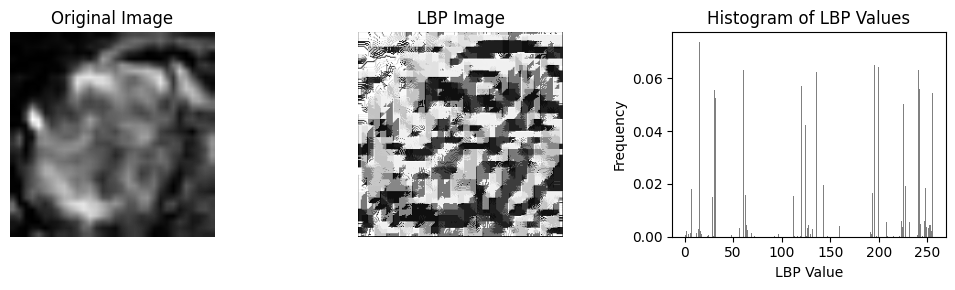

Each element in this array represents the brightness of a pixel, with values typically ranging from 0 (black) to 255 (white).


In [15]:
# Using Libraryy

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern


def edge_detection(img_path):

    # Load the image in the greyscale modeee
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Resizing the image to 224x224
    image = cv2.resize(image, (224, 224))

    # Apply LBP
    radius = 1  # radius of 1 means that the neighbors are directly adjacent to the center pixel.

    n_points = (8 * radius)  # 8 * radius because in a unit circle (radius 1), there are 8 discrete sampling points.

    lbp_image = local_binary_pattern(image, n_points, radius, method="default")

    """Example: 'default'
    
'default': Regular LBP, where each bit of the binary pattern is a direct thresholding result.
'uniform': LBP where patterns with at most two 0-1 or 1-0 transitions are considered uniform. This results in a smaller feature set.
'ror': Rotation-invariant patterns achieved by bitwise rotation.
'var': Rotation-invariant variance measures of the LBP codes.
Purpose: Specifies how to handle the binary patterns, allowing for different levels of robustness and feature reduction."""

    # grid of 1 row and 3 columns
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))

    # Original Image
    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # LBP Image
    ax[1].imshow(lbp_image, cmap="gray")
    ax[1].set_title("LBP Image")
    ax[1].axis("off")

    # Histogram of LBP Values
    n_bins = int(lbp_image.max() + 1)
    ax[2].hist(
        lbp_image.ravel(), bins=n_bins, range=(0, n_bins), density=True, color="gray"
    )
    ax[2].set_title("Histogram of LBP Values")
    ax[2].set_xlabel("LBP Value")
    ax[2].set_ylabel("Frequency")

    # Display the combined visuals
    plt.tight_layout()
    plt.show()


# Example usage
example_img_path = r"/kaggle/input/tumor-trace-dataset/train/Benign/BreaDM-Be-1806/SUB2/p-024.jpg"
edge_detection(example_img_path)
print(
    "Each element in this array represents the brightness of a pixel, with values typically ranging from 0 (black) to 255 (white)."
)


## MVM-LBP -  Mean-Variance-Median Local Binary Pattern
- It’s an advanced method for texture description and face recognition.
- Instead of comparing each neighbor to just the center pixel, we compare each neighbor to a threshold that combines the mean, variance, and median of the pixels in the 3x3 window.

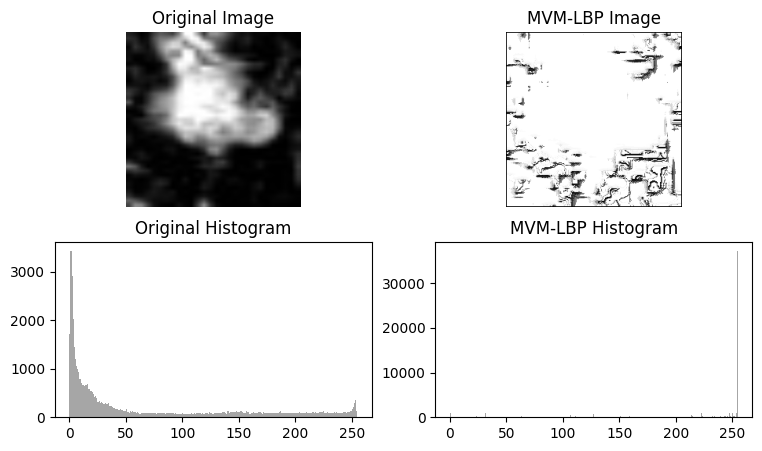

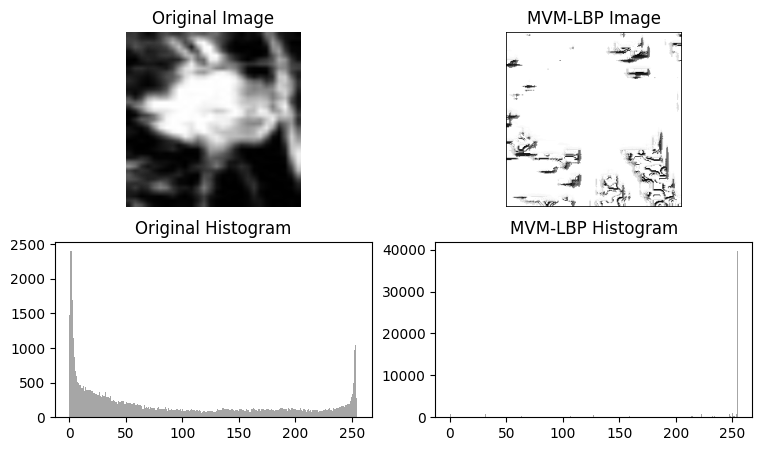

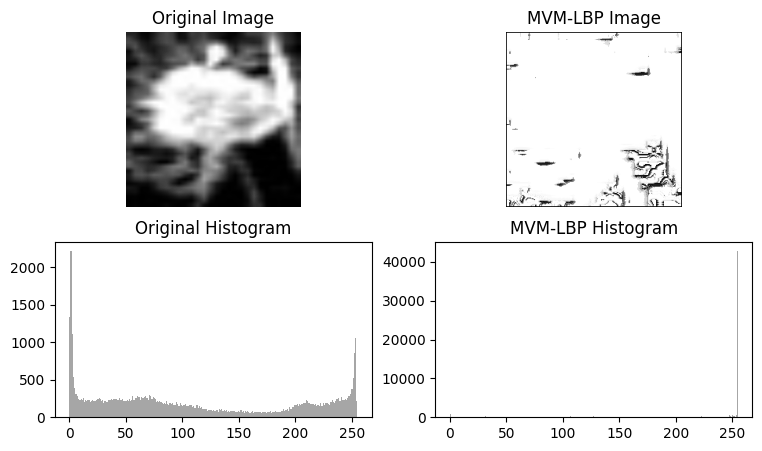

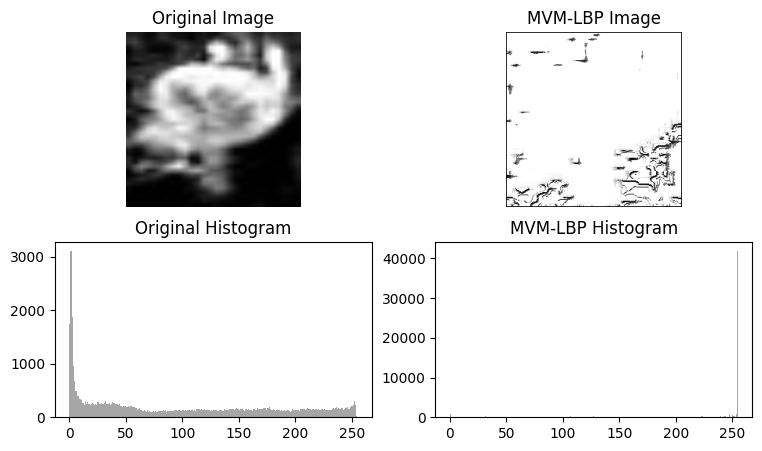

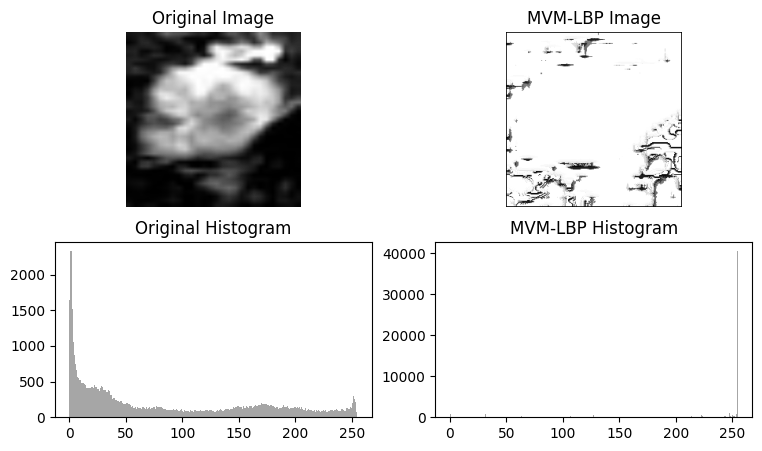

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Mean-Variance-Median Local Binary Pattern (MVM-LBP)
def calculate_mvm_lbp(image):
    rows, cols = image.shape  # Get dimensions of the image
    mvm_lbp_image = np.zeros((rows, cols), dtype=np.uint8)  # Initializingg an empty image for MVM-LBP

    for i in range(1, rows - 1):  # Loop over each pixel, excluding the border
        for j in range(1, cols - 1):
            # 3x3 window around the center pixel
            window = image[i - 1:i + 2, j - 1:j + 2]

            #  mean, variance, and median of the 3x3 window
            mean = np.mean(window)
            variance = np.var(window)
            median = np.median(window)

            # threshold =  average of mean, square root of variance, and median
            threshold = (mean + np.sqrt(variance) + median) / 3

            # 8-bit binary pattern based on the threshold
            binary_str = ''.join(['1' if window[x, y] >= threshold else '0'
                                  for x in range(3) for y in range(3) if (x, y) != (1, 1)])  # no center value is counting
            # Convert binary string to integer and set it as the new pixel value
            mvm_lbp_image[i, j] = int(binary_str, 2)

    return mvm_lbp_image

# Function to plot original and MVM-LBP images with their histograms
def plot_images_and_histograms(original, mvm_lbp_image):
    fig, ax = plt.subplots(2, 2, figsize=(9, 5))

    # Plot original image
    ax[0, 0].imshow(original, cmap='gray')
    ax[0, 0].set_title('Original Image')
    ax[0, 0].axis('off')

    # Plot MVM-LBP image
    ax[0, 1].imshow(mvm_lbp_image, cmap='gray')
    ax[0, 1].set_title('MVM-LBP Image')
    ax[0, 1].axis('off')

    # Plot histograms
    ax[1, 0].hist(original.ravel(), bins=256, color='gray', alpha=0.7)
    ax[1, 0].set_title('Original Histogram')

    ax[1, 1].hist(mvm_lbp_image.ravel(), bins=256, color='gray', alpha=0.7)
    ax[1, 1].set_title('MVM-LBP Histogram')

    plt.show()

# five images
img_paths = [
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-037.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-038.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-039.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-040.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-041.jpg"
]

# Process each image path
for img_path in img_paths:
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  #image in grayscale
    if image is None:
        print(f"Image at {img_path} could not be loaded.")
        continue
    image = cv2.resize(image, (224, 224))
    # MVM-LBP
    mvm_lbp_image = calculate_mvm_lbp(image)

    # original and MVM-LBP images with histograms
    plot_images_and_histograms(image, mvm_lbp_image)


### LBP- Mean
Sum of all values / Number of values

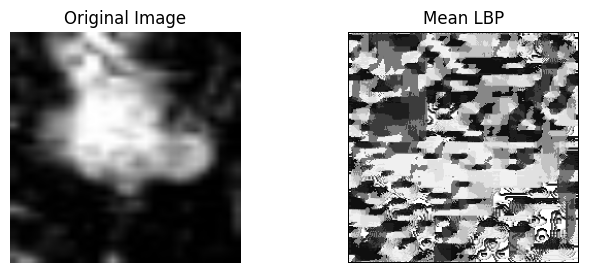

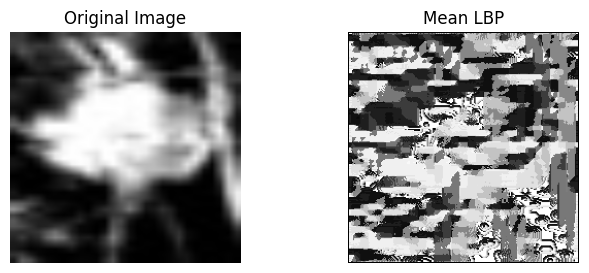

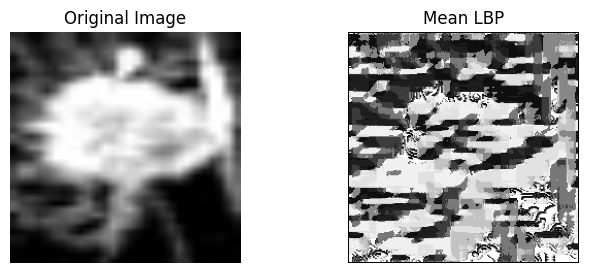

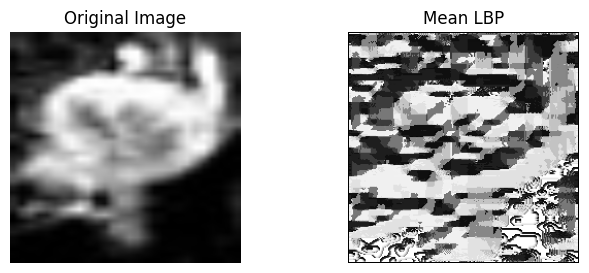

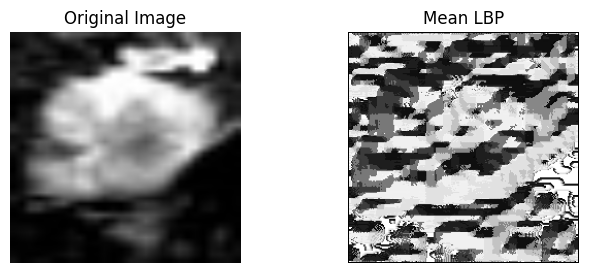

In [17]:

img_paths = [
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-037.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-038.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-039.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-040.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-041.jpg"
]

#Function for median

def mean_lbp(image): 
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    mean_lbp_image = np.zeros((rows, cols), dtype=np.uint8)


    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            center = gray[i, j]
            neighborhood = [
                gray[i-1, j-1], gray[i-1, j], gray[i-1, j+1],
                gray[i, j+1], gray[i+1, j+1], gray[i+1, j],
                gray[i+1, j-1], gray[i, j-1]
            ]
            local_mean = np.mean(neighborhood)
            binary_str = ''.join(['1' if pixel >= local_mean else '0' for pixel in neighborhood])
            mean_lbp_image[i, j] = int(binary_str, 2)
    
    return mean_lbp_image        


for img_path in img_paths:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image at {img_path} could not be loaded.")
        continue

    image = cv2.resize(image, (224, 224))
    mean_lbp_image = mean_lbp(image) #calling the function

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(mean_lbp_image, cmap='gray')
    ax[1].set_title('Mean LBP')
    ax[1].axis('off')

    plt.show()



### LBP - Median
Median is the middle value when all values are sorted in ascending order.

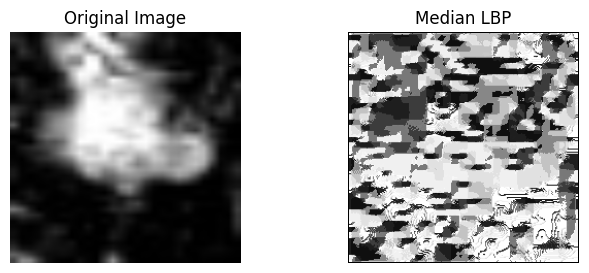

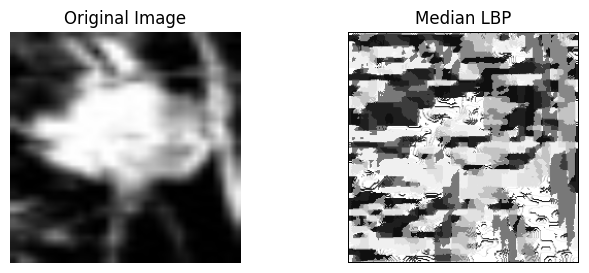

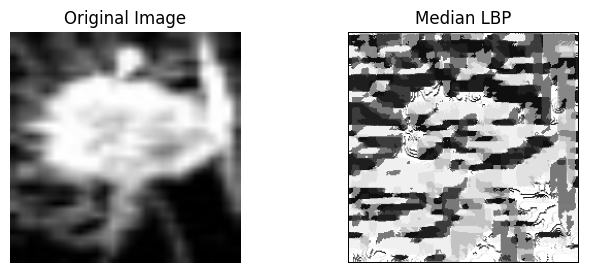

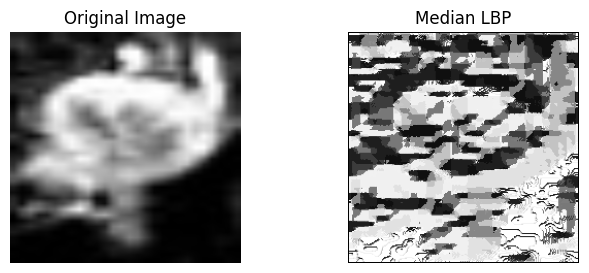

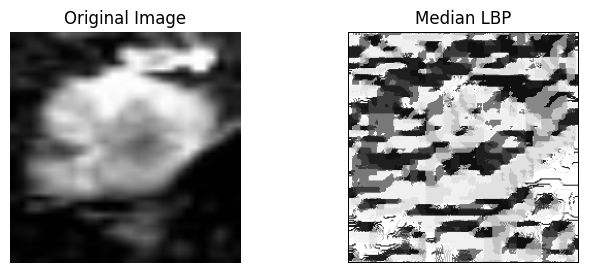

In [18]:

img_paths = [
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-037.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-038.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-039.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-040.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-041.jpg"
]


# Function for Median LBP
def median_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    median_lbp_image = np.zeros((rows, cols), dtype=np.uint8)
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            center = gray[i, j]
            neighborhood = [
                gray[i-1, j-1], gray[i-1, j], gray[i-1, j+1],
                gray[i, j+1], gray[i+1, j+1], gray[i+1, j],
                gray[i+1, j-1], gray[i, j-1]
            ]
            local_median = np.median(neighborhood)
            binary_str = ''.join(['1' if pixel >= local_median else '0' for pixel in neighborhood])
            median_lbp_image[i, j] = int(binary_str, 2)
    
    return median_lbp_image


for img_path in img_paths:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image at {img_path} could not be loaded.")
        continue

    image = cv2.resize(image, (224, 224))
    median_lbp_image = median_lbp(image) #calling the function

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(median_lbp_image, cmap='gray')
    ax[1].set_title('Median LBP')
    ax[1].axis('off')

    plt.show()



### LBP- Variance
Variance = Average of the squared differences from the Mean

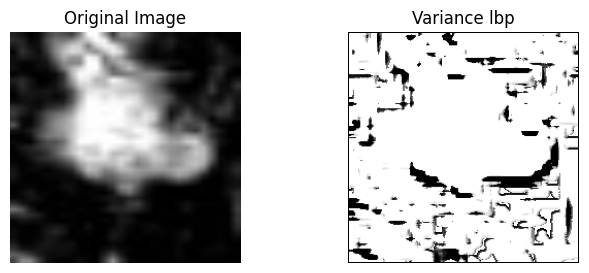

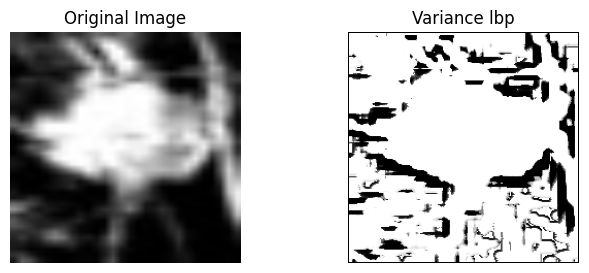

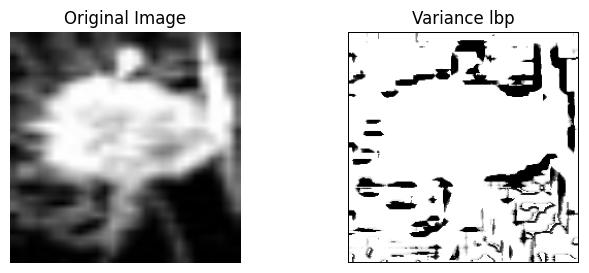

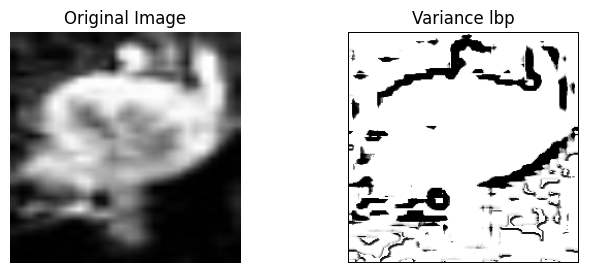

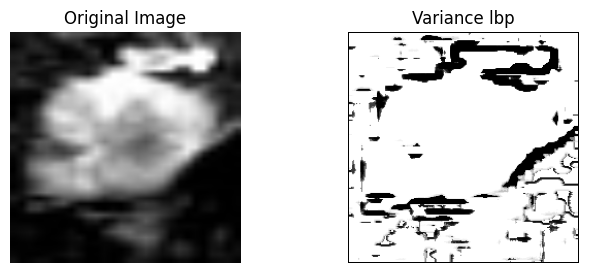

In [19]:

img_paths = [
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-037.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-038.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-039.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-040.jpg",
    r"/kaggle/input/tumor-trace-dataset/train/Malignant/BreaDM-Ma-1926/SUB1/p-041.jpg"

]

# FUNCTION for the variance 
def variance_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rows, cols = gray.shape
    variance_lbp_image = np.zeros((rows, cols), dtype=np.uint8)
    
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            center = gray[i, j]
            neighborhood = [
                gray[i-1, j-1], gray[i-1, j], gray[i-1, j+1],
                gray[i, j+1], gray[i+1, j+1], gray[i+1, j],
                gray[i+1, j-1], gray[i, j-1]
            ]
            local_variance = np.var(neighborhood)
            binary_str = ''.join(['1' if pixel >= local_variance else '0' for pixel in neighborhood])
            variance_lbp_image[i, j] = int(binary_str, 2)
    
    return variance_lbp_image
    

for img_path in img_paths:
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image at {img_path} could not be loaded.")
        continue

    image = cv2.resize(image, (224, 224))
    var_lbp_image = variance_lbp(image) #calling the function

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow( var_lbp_image, cmap='gray')
    ax[1].set_title('Variance lbp')
    ax[1].axis('off')

    plt.show()



## GLCM (Gray-Level Co-occurrence Matrix)
count the occurrences of each pair of pixel values.

In [20]:
import numpy as np

# 4x4 image
image = np.array([
    [0, 1, 1, 2],
    [2, 2, 1, 0],
    [1, 0, 0, 2],
    [3, 2, 2, 3]
])

#  GLCM matrix size based on the pixel values range
max_value = image.max()
print(max_value)
glcm = np.zeros((max_value + 1, max_value + 1), dtype=int)

# comparing each pixel with its right neighborr
rows, cols = image.shape
print(image.shape)
for row in range(rows): # The outer loop iterates over each row of the image.
    for col in range(cols - 1):  #The inner loop iterates over each column of the image & Exclude the last column to avoid out-of-bound error
        current_pixel = image[row, col]
        neighbor_pixel = image[row, col + 1]
        glcm[current_pixel, neighbor_pixel] += 1

# Print the resulting GLCM matrix
print("GLCM Matrix:")
print(glcm)


3
(4, 4)
GLCM Matrix:
[[1 1 1 0]
 [2 1 1 0]
 [0 1 2 1]
 [0 0 1 0]]


### Setting up the VggCustomMode

In [21]:
import torch
import torch.nn as nn
import torchvision.models as models

model_name = 'vgg16'
#Customvgg16 class inherit from nn.Module
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG16, self).__init__()

        # Loading pre-trained VGG16 model from tourchvision.models
        vgg16 = models.vgg16(pretrained=True)

        # Extracting the features and avgpool layers frm pretrainedmodel
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool

        # Define a new classifier nm.Sequential
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), #input and output
            nn.ReLU(inplace=True), #for activation
            nn.Dropout(), #for regularization
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):

        x = self.features(x) # Passing the input through the features layer
        x = self.avgpool(x) # Using the avgpool layer
        x = torch.flatten(x, 1) # Reshaping the output to a 2D tensor
        x = self.classifier(x) # Passing the reshaped output to the custom classifier
        return x

# printing model
if __name__ == "__main__":
    model = CustomVGG16(num_classes=2)
    print(model)
    



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 229MB/s]  


CustomVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

### Early Stopping
- Early stopping is a form of regularization used to prevent overfitting in machine learning and deep learning models.
- It involves stopping the training process before the model starts to overfit.
- The idea is to monitor the model’s performance on a validation set during the training process and stop training when the performance starts to degrade


In [22]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):

        self.patience = patience # How long to wait after last time validation loss improved.
        self.verbose = verbose #If true, prints a message for each validation loss improvement. 
        self.delta = delta # Minimum change in monotered quality to quantofy improvement
        self.path = path # file path for saving the model checkpoint
        self.trace_func = trace_func # fun to output message
        self.counter = 0 # track of epochs with no improvement.
        self.best_score = None #store the best score
        self.early_stop = False #indicating whether to stop training.
        self.val_loss_min = np.Inf # store the minimum validation loss encountered during training
        #self.best_epoch = 0 #The epoch number of the best model.
        #Epoch is used to describe one complete pass through the entire training dataset.


    def __call__(self, val_loss, model):
        # method is called at end of each epoch to check if the validation loss has improved.
        score = -val_loss

        if self.best_score is None:
            self.best_score = score #the current score is set as the best score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

# checkpoint methond
    def save_checkpoint(self, val_loss, model):

        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). save model')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [23]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(5, 5))
    #cmap = sns.color_palette(["#7469B6","#D7B26D" ,"#AD88C6", "#E1AFD1", "#FFE6E6"], as_cmap=True)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_auc(fpr, tpr, auc_score):
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='#D20062', lw=2, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], color='#D1BB9E', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


### Train Function

In [ ]:
import torch
import torch.optim as optim
from torch.amp import GradScaler, autocast
from tqdm import tqdm

def train(epoch, model, num_epochs, loader, criterion, lr_decay, lr, device):
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=lr_decay)
    scaler = GradScaler('cuda')

    model.train()
    correct = 0
    total_loss = 0

    for data, label in tqdm(loader, desc=f'Epoch {epoch}/{num_epochs}', unit='batch'):
        data, label = data.to(device), label.to(device)
        
        optimizer.zero_grad()
        with autocast('cuda'):
            output = model(data)
            loss = criterion(output, label)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(label.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f'Train Epoch: {epoch} \tLoss: {avg_loss:.6f} \tAccuracy: {accuracy:.2f}%')

    return avg_loss, accuracy


### Validation Function

In [26]:
#Validation Function

import torch
import torch.nn.functional as F
from sklearn import metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import auc as sklearn_auc
from torch.cuda.amp import GradScaler, autocast

def validation(model, val_dataloader, criterion, device, plot_metrics=False):
    name = 'val' 
    len_val_dataloader = len(val_dataloader.dataset)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []
    possibilitys = None

    with torch.no_grad():  # Ensuring no gradients are computed, saving memory and computation
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)
            val_output = model(data)  # Getting model's predictions
            val_loss += F.nll_loss(F.log_softmax(val_output, dim=1), target, reduction='sum').item()  # Calculate the loss
            pred = val_output.data.max(1)[1]  # Get the index of the max log-probability
            all_predictions.extend(pred.cpu().numpy())  # Gets the predicted class for each input
            possibility = F.softmax(val_output, dim=1).cpu().data.numpy()  # Softmax is used to convert the range of values in an array between 0-1

            if possibilitys is None:
                possibilitys = possibility
            else:
                possibilitys = np.concatenate((possibilitys, possibility), axis=0)

            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            all_targets.extend(target.cpu().numpy())  # Collect all target labels

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    cm = metrics.confusion_matrix(all_targets, all_predictions)
    print("Confusion Matrix:\n", cm)
    
    # One-hot encode the labels for AUC computation
    num_classes = val_output.shape[1]
    label_onehot = np.eye(num_classes)[all_targets.astype(int)]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilitys.ravel())
    auc_score = sklearn_auc(fpr, tpr)
    
    val_loss /= len(val_dataloader.dataset)
    accuracy = 100. * correct / len(val_dataloader.dataset)

    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_score))
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            val_loss, correct, len(val_dataloader.dataset), accuracy))
    
    if plot_metrics == True:
        
        classification_rep = classification_report(all_targets, all_predictions, target_names=["benign", "malignant"])
        print(f'Classification Report of Validation :\n {classification_rep}\n')
    
        print("Confusion Matrix of Validation :\n")
        plot_confusion_matrix(cm, classes=['benign', 'malignant'])
        plot_auc(fpr, tpr, auc_score)

    return accuracy, val_loss, auc_score


### Test Function

In [27]:
from sklearn import metrics
import numpy as np
import torch.nn.functional as F

def test(model, test_dataloader, criterion, device):
    name = 'test'
    len_test_dataloader = len(test_dataloader.dataset)
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []
    all_probabilities = []

    with torch.no_grad():  # Ensuring no gradients are computed, saving memory and computation.
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)

            test_output = model(data)  # Getting model's predictions
            test_loss += criterion(test_output, target).item()  # Calculate the loss
            pred = test_output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability

            all_predictions.extend(pred.cpu().numpy())  # Gets the predicted class for each input.
            all_targets.extend(target.cpu().numpy())  # Get the true labels
            probabilities = F.softmax(test_output, dim=1).cpu().numpy()  # softmax is used to convert the range of values in an array between 0-1
            all_probabilities.extend(probabilities)

            correct += pred.eq(target.view_as(pred)).sum().item()

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probabilities = np.array(all_probabilities)

    # Classification metrics - accuracy, f1 score
    classification_rep = metrics.classification_report(all_targets, all_predictions, target_names=['benign', 'malignant'], digits=4)
    print('Classification Report of Test :')
    print(classification_rep)

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_targets, all_predictions)
    print('Confusion Matrix:')
    print(cm)
    plot_confusion_matrix(cm, ['benign', 'malignant'])

    # ROC AUC
    num_classes = all_probabilities.shape[1]
    label_onehot = np.eye(num_classes)[all_targets.astype(int)]

    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), all_probabilities.ravel())
    auc_value = metrics.auc(fpr, tpr)
    plot_auc(fpr, tpr, auc_value)

    test_loss /= len_test_dataloader
    accuracy = 100. * correct / len_test_dataloader
    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_value))
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(name, test_loss, correct, len_test_dataloader, accuracy))

    return accuracy, test_loss, auc_value


In [37]:

model.to(device)  # here cudu device
model = CustomVGG16(num_classes=2).to(device)
criterion = torch.nn.CrossEntropyLoss()
best_accuracy = 0
total_epochs = 50
lr = 0.001
momentum = 0.9
no_cuda = False
log_interval = 10 
lr_decay = 1e-4
model_name = "vgg16"

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


### Model Traning

Epoch 1/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 1 	Loss: 0.401779 	Accuracy: 81.22%


Confusion Matrix:
 [[ 302  106]
 [ 146 1430]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9529

Validation set: Average loss: 0.2727, Accuracy: 1732/1989 (87.08%)

Best model saved with AUC 0.9529 at epoch 1 to ./VGG16_Model/vgg16_best.pth
Validation loss decreased (inf --> 0.272742). save model


Epoch 2/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 2 	Loss: 0.274434 	Accuracy: 87.87%


Confusion Matrix:
 [[ 261  147]
 [ 117 1459]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9485

Validation set: Average loss: 0.3057, Accuracy: 1720/1989 (86.48%)

EarlyStopping counter: 1 out of 20


Epoch 3/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 3 	Loss: 0.212132 	Accuracy: 90.88%


Confusion Matrix:
 [[ 232  176]
 [ 100 1476]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9515

Validation set: Average loss: 0.2751, Accuracy: 1708/1989 (85.87%)

EarlyStopping counter: 2 out of 20


Epoch 4/50: 100%|██████████| 638/638 [02:42<00:00,  3.91batch/s]

Train Epoch: 4 	Loss: 0.170953 	Accuracy: 92.76%


Confusion Matrix:
 [[ 269  139]
 [ 141 1435]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9497

Validation set: Average loss: 0.3314, Accuracy: 1704/1989 (85.67%)

EarlyStopping counter: 3 out of 20


Epoch 5/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 5 	Loss: 0.143552 	Accuracy: 94.03%


Confusion Matrix:
 [[ 311   97]
 [ 218 1358]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9445

Validation set: Average loss: 0.3164, Accuracy: 1669/1989 (83.91%)

EarlyStopping counter: 4 out of 20


Epoch 6/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 6 	Loss: 0.127560 	Accuracy: 94.76%


Confusion Matrix:
 [[ 347   61]
 [ 256 1320]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9373

Validation set: Average loss: 0.3797, Accuracy: 1667/1989 (83.81%)

EarlyStopping counter: 5 out of 20


Epoch 7/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 7 	Loss: 0.113142 	Accuracy: 95.55%


Confusion Matrix:
 [[ 326   82]
 [ 243 1333]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9296

Validation set: Average loss: 0.3813, Accuracy: 1659/1989 (83.41%)

EarlyStopping counter: 6 out of 20


Epoch 8/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 8 	Loss: 0.096285 	Accuracy: 96.15%


Confusion Matrix:
 [[ 308  100]
 [ 137 1439]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9602

Validation set: Average loss: 0.2666, Accuracy: 1747/1989 (87.83%)

Best model saved with AUC 0.9602 at epoch 8 to ./VGG16_Model/vgg16_best.pth
Validation loss decreased (0.272742 --> 0.266616). save model


Epoch 9/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 9 	Loss: 0.087983 	Accuracy: 96.50%


Confusion Matrix:
 [[ 305  103]
 [ 168 1408]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9541

Validation set: Average loss: 0.3462, Accuracy: 1713/1989 (86.12%)

EarlyStopping counter: 1 out of 20


Epoch 10/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 10 	Loss: 0.079860 	Accuracy: 96.95%


Confusion Matrix:
 [[ 305  103]
 [ 180 1396]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9483

Validation set: Average loss: 0.4143, Accuracy: 1701/1989 (85.52%)

Model saved at epoch 10 to ./VGG16_Model/vgg16_epoch_10.pth
EarlyStopping counter: 2 out of 20


Epoch 11/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 11 	Loss: 0.074241 	Accuracy: 97.03%


Confusion Matrix:
 [[ 302  106]
 [ 177 1399]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9444

Validation set: Average loss: 0.3911, Accuracy: 1701/1989 (85.52%)

EarlyStopping counter: 3 out of 20


Epoch 12/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 12 	Loss: 0.070983 	Accuracy: 97.31%


Confusion Matrix:
 [[ 330   78]
 [ 172 1404]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9530

Validation set: Average loss: 0.3687, Accuracy: 1734/1989 (87.18%)

EarlyStopping counter: 4 out of 20


Epoch 13/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 13 	Loss: 0.061321 	Accuracy: 97.57%


Confusion Matrix:
 [[ 298  110]
 [ 154 1422]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9527

Validation set: Average loss: 0.3708, Accuracy: 1720/1989 (86.48%)

EarlyStopping counter: 5 out of 20


Epoch 14/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 14 	Loss: 0.054979 	Accuracy: 97.93%


Confusion Matrix:
 [[ 295  113]
 [ 175 1401]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9431

Validation set: Average loss: 0.5017, Accuracy: 1696/1989 (85.27%)

EarlyStopping counter: 6 out of 20


Epoch 15/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 15 	Loss: 0.051875 	Accuracy: 97.92%


Confusion Matrix:
 [[ 333   75]
 [ 200 1376]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9520

Validation set: Average loss: 0.4212, Accuracy: 1709/1989 (85.92%)

EarlyStopping counter: 7 out of 20


Epoch 16/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 16 	Loss: 0.047153 	Accuracy: 98.05%


Confusion Matrix:
 [[ 316   92]
 [ 204 1372]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9429

Validation set: Average loss: 0.4568, Accuracy: 1688/1989 (84.87%)

EarlyStopping counter: 8 out of 20


Epoch 17/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 17 	Loss: 0.042808 	Accuracy: 98.28%


Confusion Matrix:
 [[ 271  137]
 [ 171 1405]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9455

Validation set: Average loss: 0.4551, Accuracy: 1676/1989 (84.26%)

EarlyStopping counter: 9 out of 20


Epoch 18/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 18 	Loss: 0.044939 	Accuracy: 98.09%


Confusion Matrix:
 [[ 289  119]
 [ 143 1433]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9557

Validation set: Average loss: 0.4687, Accuracy: 1722/1989 (86.58%)

EarlyStopping counter: 10 out of 20


Epoch 19/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 19 	Loss: 0.043681 	Accuracy: 98.36%


Confusion Matrix:
 [[ 319   89]
 [ 174 1402]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9519

Validation set: Average loss: 0.4207, Accuracy: 1721/1989 (86.53%)

EarlyStopping counter: 11 out of 20


Epoch 20/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 20 	Loss: 0.035226 	Accuracy: 98.62%


Confusion Matrix:
 [[ 271  137]
 [ 132 1444]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9505

Validation set: Average loss: 0.4825, Accuracy: 1715/1989 (86.22%)

Model saved at epoch 20 to ./VGG16_Model/vgg16_epoch_20.pth
EarlyStopping counter: 12 out of 20


Epoch 21/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 21 	Loss: 0.037156 	Accuracy: 98.53%


Confusion Matrix:
 [[ 281  127]
 [ 169 1407]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9476

Validation set: Average loss: 0.5276, Accuracy: 1688/1989 (84.87%)

EarlyStopping counter: 13 out of 20


Epoch 22/50: 100%|██████████| 638/638 [02:42<00:00,  3.91batch/s]

Train Epoch: 22 	Loss: 0.032829 	Accuracy: 98.71%


Confusion Matrix:
 [[ 312   96]
 [ 160 1416]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9542

Validation set: Average loss: 0.3741, Accuracy: 1728/1989 (86.88%)

EarlyStopping counter: 14 out of 20


Epoch 23/50: 100%|██████████| 638/638 [02:42<00:00,  3.91batch/s]

Train Epoch: 23 	Loss: 0.034585 	Accuracy: 98.62%


Confusion Matrix:
 [[ 279  129]
 [ 116 1460]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9577

Validation set: Average loss: 0.4166, Accuracy: 1739/1989 (87.43%)

EarlyStopping counter: 15 out of 20


Epoch 24/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 24 	Loss: 0.030603 	Accuracy: 98.79%


Confusion Matrix:
 [[ 288  120]
 [ 131 1445]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9602

Validation set: Average loss: 0.4433, Accuracy: 1733/1989 (87.13%)

EarlyStopping counter: 16 out of 20


Epoch 25/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 25 	Loss: 0.029198 	Accuracy: 98.86%


Confusion Matrix:
 [[ 287  121]
 [ 171 1405]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9471

Validation set: Average loss: 0.5607, Accuracy: 1692/1989 (85.07%)

EarlyStopping counter: 17 out of 20


Epoch 26/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 26 	Loss: 0.027894 	Accuracy: 98.91%


Confusion Matrix:
 [[ 274  134]
 [ 167 1409]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9460

Validation set: Average loss: 0.6543, Accuracy: 1683/1989 (84.62%)

EarlyStopping counter: 18 out of 20


Epoch 27/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 27 	Loss: 0.025132 	Accuracy: 98.99%


Confusion Matrix:
 [[ 260  148]
 [  92 1484]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9570

Validation set: Average loss: 0.5139, Accuracy: 1744/1989 (87.68%)

EarlyStopping counter: 19 out of 20


Epoch 28/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 28 	Loss: 0.027155 	Accuracy: 98.94%


Confusion Matrix:
 [[ 279  129]
 [ 135 1441]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9539

Validation set: Average loss: 0.5133, Accuracy: 1720/1989 (86.48%)

EarlyStopping counter: 20 out of 20
Early stopping
Confusion Matrix:
 [[ 279  129]
 [ 135 1441]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9539

Validation set: Average loss: 0.5133, Accuracy: 1720/1989 (86.48%)

Classification Report of Validation :
               precision    recall  f1-score   support

      benign       0.67      0.68      0.68       408
   malignant       0.92      0.91      0.92      1576

    accuracy                           0.87      1984
   macro avg       0.80      0.80      0.80      1984
weighted avg       0.87      0.87      0.87      1984


Confusion Matrix of Validation :



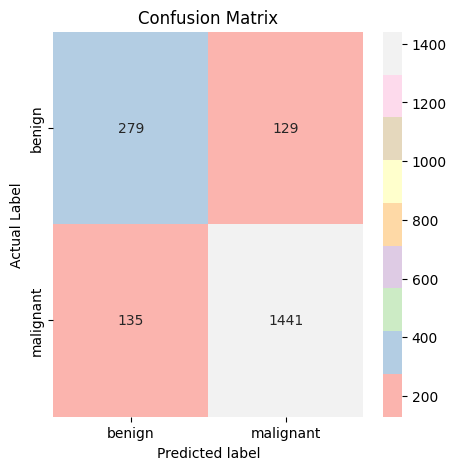

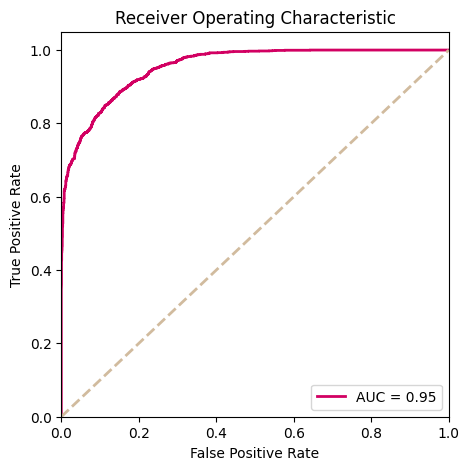

Testing the model on the test dataset
Classification Report of Test :
              precision    recall  f1-score   support

      benign     0.6681    0.4871    0.5634      1938
   malignant     0.8171    0.9045    0.8586      4910

    accuracy                         0.7864      6848
   macro avg     0.7426    0.6958    0.7110      6848
weighted avg     0.7749    0.7864    0.7750      6848

Confusion Matrix:
[[ 944  994]
 [ 469 4441]]


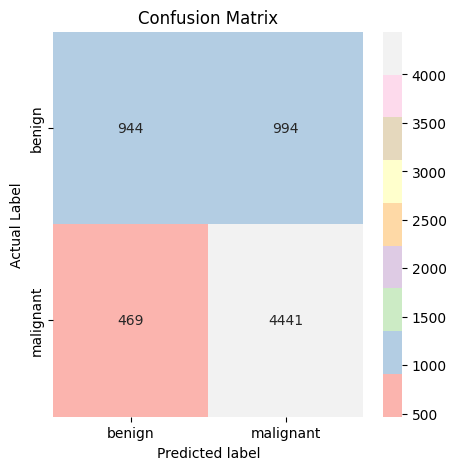

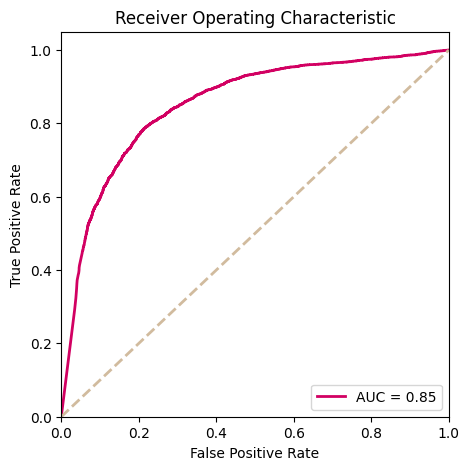

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8518

test set: Average loss: 0.0585, Accuracy: 5385/6851 (78.60%)



In [41]:
# model training
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Early stopping setup
early_stop = EarlyStopping(patience=20, verbose=True)

best_accuracy = 0
model_save_dir = './VGG16_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

for epoch in range(1, total_epochs + 1):
    train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr, device)

    with torch.no_grad():
        val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=False)

    # Save model every 5 epochs
    if epoch % 10 == 0:
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch} to {model_save_path}')

    if val_auc > best_accuracy:
        best_accuracy = val_auc
        best_model_path = os.path.join(model_save_dir, f'{model_name}_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with AUC {best_accuracy:.4f} at epoch {epoch} to {best_model_path}')

    early_stop(val_loss, model)
    if early_stop.early_stop:
        print("Early stopping")
        # Ploting the confusion matrix and ROC curve for the final epoch
        with torch.no_grad():
            val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=True)
        break

# Evaluating the model on the test dataset
print("Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

### Resnet 18 model


In [42]:
class Resnet18(nn.Module):

    def __init__(self, num_classes=2):
        super(Resnet18, self).__init__()

        model_resnet18 = models.resnet18(pretrained=True)

        self.conv1 = model_resnet18.conv1  # convolutional function
        self.bn1 = model_resnet18.bn1  # batch normalization
        self.relu = model_resnet18.relu  # relu is your activation function.
        self.maxpool = model_resnet18.maxpool  # maxpool is basically taking the biggest value per sub-matrix

        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4  # these layers are use for deepening the layers in the architecture which will increase

        self.avgpool = model_resnet18.avgpool
        self._features = model_resnet18.fc.in_features

        self.fc = nn.Linear(self._features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [43]:
model_name = 'resnet18'
model = Resnet18(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


### Training the Resnet18

Epoch 1/50: 100%|██████████| 638/638 [01:00<00:00, 10.60batch/s]

Train Epoch: 1 	Loss: 0.372380 	Accuracy: 82.87%


Confusion Matrix:
 [[ 309   99]
 [ 272 1304]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9231

Validation set: Average loss: 0.3510, Accuracy: 1613/1989 (81.10%)

Best model saved with AUC 0.9231 at epoch 1 to ./Resnet18_Model/resnet18_best.pth
Validation loss decreased (inf --> 0.350992). save model


Epoch 2/50: 100%|██████████| 638/638 [01:00<00:00, 10.58batch/s]

Train Epoch: 2 	Loss: 0.247208 	Accuracy: 89.10%


Confusion Matrix:
 [[ 317   91]
 [ 260 1316]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9298

Validation set: Average loss: 0.3450, Accuracy: 1633/1989 (82.10%)

Best model saved with AUC 0.9298 at epoch 2 to ./Resnet18_Model/resnet18_best.pth
Validation loss decreased (0.350992 --> 0.344978). save model


Epoch 3/50: 100%|██████████| 638/638 [01:00<00:00, 10.51batch/s]

Train Epoch: 3 	Loss: 0.188254 	Accuracy: 92.18%


Confusion Matrix:
 [[ 298  110]
 [ 217 1359]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9320

Validation set: Average loss: 0.3719, Accuracy: 1657/1989 (83.31%)

Best model saved with AUC 0.9320 at epoch 3 to ./Resnet18_Model/resnet18_best.pth
EarlyStopping counter: 1 out of 20


Epoch 4/50: 100%|██████████| 638/638 [01:00<00:00, 10.57batch/s]

Train Epoch: 4 	Loss: 0.147379 	Accuracy: 93.93%


Confusion Matrix:
 [[ 315   93]
 [ 262 1314]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9218

Validation set: Average loss: 0.4531, Accuracy: 1629/1989 (81.90%)

EarlyStopping counter: 2 out of 20


Epoch 5/50: 100%|██████████| 638/638 [01:00<00:00, 10.63batch/s]

Train Epoch: 5 	Loss: 0.123272 	Accuracy: 94.94%


Confusion Matrix:
 [[ 283  125]
 [ 133 1443]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9537

Validation set: Average loss: 0.3141, Accuracy: 1726/1989 (86.78%)

Best model saved with AUC 0.9537 at epoch 5 to ./Resnet18_Model/resnet18_best.pth
Validation loss decreased (0.344978 --> 0.314133). save model


Epoch 6/50: 100%|██████████| 638/638 [01:00<00:00, 10.63batch/s]

Train Epoch: 6 	Loss: 0.105507 	Accuracy: 95.78%


Confusion Matrix:
 [[ 323   85]
 [ 201 1375]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9479

Validation set: Average loss: 0.3653, Accuracy: 1698/1989 (85.37%)

EarlyStopping counter: 1 out of 20


Epoch 7/50: 100%|██████████| 638/638 [00:59<00:00, 10.69batch/s]

Train Epoch: 7 	Loss: 0.092248 	Accuracy: 96.27%


Confusion Matrix:
 [[ 269  139]
 [  97 1479]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9558

Validation set: Average loss: 0.3609, Accuracy: 1748/1989 (87.88%)

Best model saved with AUC 0.9558 at epoch 7 to ./Resnet18_Model/resnet18_best.pth
EarlyStopping counter: 2 out of 20


Epoch 8/50: 100%|██████████| 638/638 [00:59<00:00, 10.66batch/s]

Train Epoch: 8 	Loss: 0.082025 	Accuracy: 96.67%


Confusion Matrix:
 [[ 316   92]
 [ 196 1380]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9442

Validation set: Average loss: 0.3691, Accuracy: 1696/1989 (85.27%)

EarlyStopping counter: 3 out of 20


Epoch 9/50: 100%|██████████| 638/638 [00:59<00:00, 10.67batch/s]

Train Epoch: 9 	Loss: 0.071961 	Accuracy: 97.14%


Confusion Matrix:
 [[ 263  145]
 [  84 1492]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9409

Validation set: Average loss: 0.4819, Accuracy: 1755/1989 (88.24%)

EarlyStopping counter: 4 out of 20


Epoch 10/50: 100%|██████████| 638/638 [01:00<00:00, 10.63batch/s]

Train Epoch: 10 	Loss: 0.067394 	Accuracy: 97.43%


Confusion Matrix:
 [[ 282  126]
 [ 233 1343]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9081

Validation set: Average loss: 0.5469, Accuracy: 1625/1989 (81.70%)

Model saved at epoch 10 to ./Resnet18_Model/resnet18_epoch_10.pth
EarlyStopping counter: 5 out of 20


Epoch 11/50: 100%|██████████| 638/638 [00:59<00:00, 10.66batch/s]

Train Epoch: 11 	Loss: 0.065071 	Accuracy: 97.43%


Confusion Matrix:
 [[ 291  117]
 [ 263 1313]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9071

Validation set: Average loss: 0.6547, Accuracy: 1604/1989 (80.64%)

EarlyStopping counter: 6 out of 20


Epoch 12/50: 100%|██████████| 638/638 [01:00<00:00, 10.63batch/s]

Train Epoch: 12 	Loss: 0.050550 	Accuracy: 98.01%


Confusion Matrix:
 [[ 309   99]
 [ 185 1391]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9442

Validation set: Average loss: 0.4668, Accuracy: 1700/1989 (85.47%)

EarlyStopping counter: 7 out of 20


Epoch 13/50: 100%|██████████| 638/638 [00:59<00:00, 10.64batch/s]

Train Epoch: 13 	Loss: 0.052390 	Accuracy: 98.01%


Confusion Matrix:
 [[ 322   86]
 [ 183 1393]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9461

Validation set: Average loss: 0.4553, Accuracy: 1715/1989 (86.22%)

EarlyStopping counter: 8 out of 20


Epoch 14/50: 100%|██████████| 638/638 [00:59<00:00, 10.68batch/s]

Train Epoch: 14 	Loss: 0.044846 	Accuracy: 98.32%


Confusion Matrix:
 [[ 341   67]
 [ 268 1308]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9252

Validation set: Average loss: 0.5723, Accuracy: 1649/1989 (82.91%)

EarlyStopping counter: 9 out of 20


Epoch 15/50: 100%|██████████| 638/638 [00:59<00:00, 10.72batch/s]

Train Epoch: 15 	Loss: 0.039314 	Accuracy: 98.48%


Confusion Matrix:
 [[ 330   78]
 [ 224 1352]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9386

Validation set: Average loss: 0.4957, Accuracy: 1682/1989 (84.57%)

EarlyStopping counter: 10 out of 20


Epoch 16/50: 100%|██████████| 638/638 [00:59<00:00, 10.66batch/s]

Train Epoch: 16 	Loss: 0.041345 	Accuracy: 98.38%


Confusion Matrix:
 [[ 310   98]
 [ 199 1377]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9304

Validation set: Average loss: 0.5432, Accuracy: 1687/1989 (84.82%)

EarlyStopping counter: 11 out of 20


Epoch 17/50: 100%|██████████| 638/638 [01:01<00:00, 10.32batch/s]

Train Epoch: 17 	Loss: 0.042890 	Accuracy: 98.34%


Confusion Matrix:
 [[ 272  136]
 [ 159 1417]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9381

Validation set: Average loss: 0.5392, Accuracy: 1689/1989 (84.92%)

EarlyStopping counter: 12 out of 20


Epoch 18/50: 100%|██████████| 638/638 [01:02<00:00, 10.28batch/s]

Train Epoch: 18 	Loss: 0.033202 	Accuracy: 98.74%


Confusion Matrix:
 [[ 292  116]
 [ 191 1385]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9419

Validation set: Average loss: 0.5242, Accuracy: 1677/1989 (84.31%)

EarlyStopping counter: 13 out of 20


Epoch 19/50: 100%|██████████| 638/638 [01:00<00:00, 10.52batch/s]

Train Epoch: 19 	Loss: 0.032131 	Accuracy: 98.70%


Confusion Matrix:
 [[ 276  132]
 [  81 1495]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9566

Validation set: Average loss: 0.4877, Accuracy: 1771/1989 (89.04%)

Best model saved with AUC 0.9566 at epoch 19 to ./Resnet18_Model/resnet18_best.pth
EarlyStopping counter: 14 out of 20


Epoch 20/50: 100%|██████████| 638/638 [01:00<00:00, 10.60batch/s]

Train Epoch: 20 	Loss: 0.031319 	Accuracy: 98.78%


Confusion Matrix:
 [[ 253  155]
 [  81 1495]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9558

Validation set: Average loss: 0.5006, Accuracy: 1748/1989 (87.88%)

Model saved at epoch 20 to ./Resnet18_Model/resnet18_epoch_20.pth
EarlyStopping counter: 15 out of 20


Epoch 21/50: 100%|██████████| 638/638 [01:00<00:00, 10.56batch/s]

Train Epoch: 21 	Loss: 0.029361 	Accuracy: 98.92%


Confusion Matrix:
 [[ 251  157]
 [ 134 1442]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9381

Validation set: Average loss: 0.5721, Accuracy: 1693/1989 (85.12%)

EarlyStopping counter: 16 out of 20


Epoch 22/50: 100%|██████████| 638/638 [01:00<00:00, 10.59batch/s]

Train Epoch: 22 	Loss: 0.031086 	Accuracy: 98.85%


Confusion Matrix:
 [[ 259  149]
 [ 112 1464]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9442

Validation set: Average loss: 0.5866, Accuracy: 1723/1989 (86.63%)

EarlyStopping counter: 17 out of 20


Epoch 23/50: 100%|██████████| 638/638 [01:00<00:00, 10.60batch/s]

Train Epoch: 23 	Loss: 0.029120 	Accuracy: 98.82%


Confusion Matrix:
 [[ 281  127]
 [ 140 1436]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9417

Validation set: Average loss: 0.6010, Accuracy: 1717/1989 (86.32%)

EarlyStopping counter: 18 out of 20


Epoch 24/50: 100%|██████████| 638/638 [01:00<00:00, 10.54batch/s]

Train Epoch: 24 	Loss: 0.027832 	Accuracy: 98.90%


Confusion Matrix:
 [[ 304  104]
 [ 168 1408]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9544

Validation set: Average loss: 0.4379, Accuracy: 1712/1989 (86.07%)

EarlyStopping counter: 19 out of 20


Epoch 25/50: 100%|██████████| 638/638 [00:59<00:00, 10.65batch/s]

Train Epoch: 25 	Loss: 0.022238 	Accuracy: 99.11%


Confusion Matrix:
 [[ 300  108]
 [ 142 1434]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9513

Validation set: Average loss: 0.4663, Accuracy: 1734/1989 (87.18%)

EarlyStopping counter: 20 out of 20
Early stopping
Confusion Matrix:
 [[ 300  108]
 [ 142 1434]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9513

Validation set: Average loss: 0.4663, Accuracy: 1734/1989 (87.18%)

Classification Report of Validation :
               precision    recall  f1-score   support

      benign       0.68      0.74      0.71       408
   malignant       0.93      0.91      0.92      1576

    accuracy                           0.87      1984
   macro avg       0.80      0.82      0.81      1984
weighted avg       0.88      0.87      0.88      1984


Confusion Matrix of Validation :



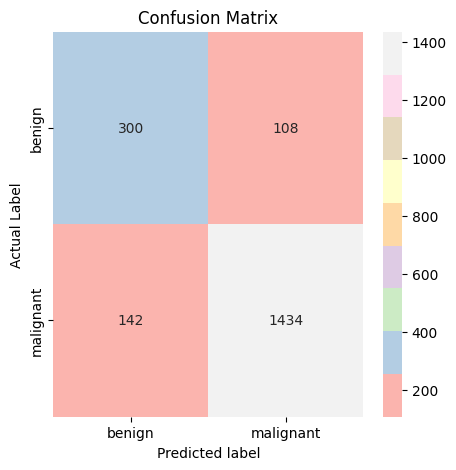

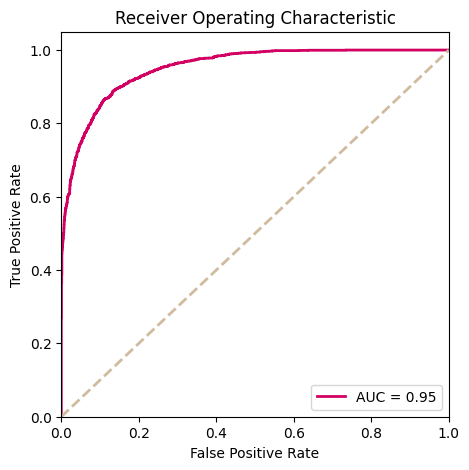

Testing the model on the test dataset
Classification Report of Test :
              precision    recall  f1-score   support

      benign     0.6217    0.5655    0.5923      1938
   malignant     0.8344    0.8642    0.8490      4910

    accuracy                         0.7796      6848
   macro avg     0.7280    0.7148    0.7206      6848
weighted avg     0.7742    0.7796    0.7764      6848

Confusion Matrix:
[[1096  842]
 [ 667 4243]]


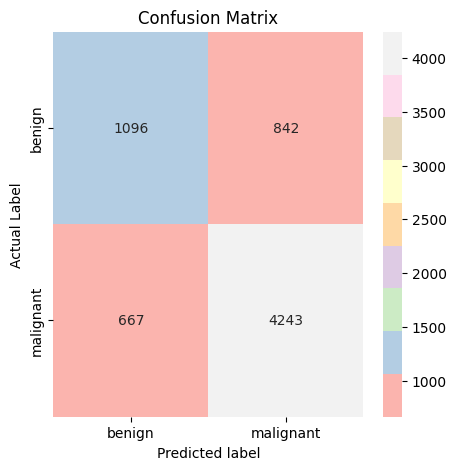

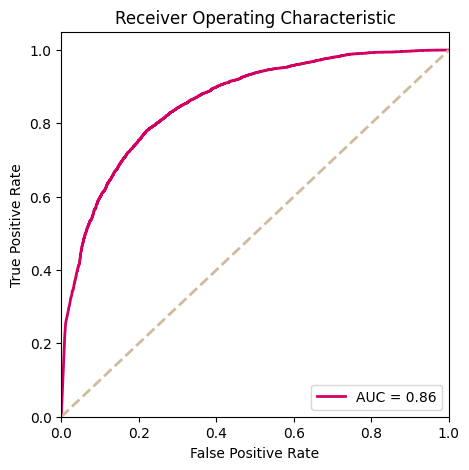

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8591

test set: Average loss: 0.0424, Accuracy: 5339/6851 (77.93%)



In [44]:
# model training
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Early stopping setup
early_stop = EarlyStopping(patience=20, verbose=True)

best_accuracy = 0
model_save_dir = './Resnet18_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

for epoch in range(1, total_epochs + 1):
    train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr, device)

    with torch.no_grad():
        val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=False)

    # Save model every 5 epochs
    if epoch % 10 == 0:
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch} to {model_save_path}')

    if val_auc > best_accuracy:
        best_accuracy = val_auc
        best_model_path = os.path.join(model_save_dir, f'{model_name}_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with AUC {best_accuracy:.4f} at epoch {epoch} to {best_model_path}')

    early_stop(val_loss, model)
    if early_stop.early_stop:
        print("Early stopping")
        # Ploting the confusion matrix and ROC curve for the final epoch
        with torch.no_grad():
            val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=True)
        break

# Evaluating the model on the test dataset
print("Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

### Resnet 50 model

In [45]:
class Resnet50(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet50, self).__init__()

        model_resnet50 = models.resnet50(pretrained=True)

        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool

        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4

        self.avgpool = model_resnet50.avgpool
        self._features = model_resnet50.fc.in_features

        self.fc = nn.Linear(self._features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

In [46]:
model_name = 'resnet50'
model = Resnet50(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s] 


Resnet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

Epoch 1/50: 100%|██████████| 638/638 [01:41<00:00,  6.31batch/s]


Train Epoch: 1 	Loss: 0.359379 	Accuracy: 83.80%
Confusion Matrix:
 [[ 330   78]
 [ 258 1318]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9280

Validation set: Average loss: 0.3420, Accuracy: 1648/1989 (82.86%)

Best model saved with AUC 0.9280 at epoch 1 to ./Resnet50_Model/resnet50_best.pth
Validation loss decreased (inf --> 0.341955). save model


Epoch 2/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]

Train Epoch: 2 	Loss: 0.216008 	Accuracy: 90.82%


Confusion Matrix:
 [[ 348   60]
 [ 194 1382]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9631

Validation set: Average loss: 0.2530, Accuracy: 1730/1989 (86.98%)

Best model saved with AUC 0.9631 at epoch 2 to ./Resnet50_Model/resnet50_best.pth
Validation loss decreased (0.341955 --> 0.252968). save model


Epoch 3/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 3 	Loss: 0.150859 	Accuracy: 93.95%
Confusion Matrix:
 [[ 308  100]
 [ 178 1398]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9537

Validation set: Average loss: 0.3246, Accuracy: 1706/1989 (85.77%)

EarlyStopping counter: 1 out of 20


Epoch 4/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 4 	Loss: 0.115881 	Accuracy: 95.38%
Confusion Matrix:
 [[ 282  126]
 [ 142 1434]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9525

Validation set: Average loss: 0.3155, Accuracy: 1716/1989 (86.27%)

EarlyStopping counter: 2 out of 20


Epoch 5/50: 100%|██████████| 638/638 [01:40<00:00,  6.33batch/s]


Train Epoch: 5 	Loss: 0.097376 	Accuracy: 96.15%
Confusion Matrix:
 [[ 286  122]
 [ 180 1396]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9516

Validation set: Average loss: 0.3493, Accuracy: 1682/1989 (84.57%)

EarlyStopping counter: 3 out of 20


Epoch 6/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 6 	Loss: 0.077271 	Accuracy: 96.93%
Confusion Matrix:
 [[ 327   81]
 [ 198 1378]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9506

Validation set: Average loss: 0.4353, Accuracy: 1705/1989 (85.72%)

EarlyStopping counter: 4 out of 20


Epoch 7/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 7 	Loss: 0.067978 	Accuracy: 97.28%
Confusion Matrix:
 [[ 306  102]
 [ 181 1395]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9395

Validation set: Average loss: 0.4664, Accuracy: 1701/1989 (85.52%)

EarlyStopping counter: 5 out of 20


Epoch 8/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 8 	Loss: 0.060038 	Accuracy: 97.84%
Confusion Matrix:
 [[ 293  115]
 [ 105 1471]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9552

Validation set: Average loss: 0.4061, Accuracy: 1764/1989 (88.69%)

EarlyStopping counter: 6 out of 20


Epoch 9/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 9 	Loss: 0.052918 	Accuracy: 97.84%
Confusion Matrix:
 [[ 303  105]
 [ 115 1461]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9477

Validation set: Average loss: 0.4829, Accuracy: 1764/1989 (88.69%)

EarlyStopping counter: 7 out of 20


Epoch 10/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 10 	Loss: 0.042771 	Accuracy: 98.30%
Confusion Matrix:
 [[ 320   88]
 [ 204 1372]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9460

Validation set: Average loss: 0.4725, Accuracy: 1692/1989 (85.07%)

Model saved at epoch 10 to ./Resnet50_Model/resnet50_epoch_10.pth
EarlyStopping counter: 8 out of 20


Epoch 11/50: 100%|██████████| 638/638 [01:40<00:00,  6.33batch/s]


Train Epoch: 11 	Loss: 0.037666 	Accuracy: 98.48%
Confusion Matrix:
 [[ 323   85]
 [ 146 1430]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9482

Validation set: Average loss: 0.5089, Accuracy: 1753/1989 (88.13%)

EarlyStopping counter: 9 out of 20


Epoch 12/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 12 	Loss: 0.033597 	Accuracy: 98.71%
Confusion Matrix:
 [[ 269  139]
 [  94 1482]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9581

Validation set: Average loss: 0.4704, Accuracy: 1751/1989 (88.03%)

EarlyStopping counter: 10 out of 20


Epoch 13/50: 100%|██████████| 638/638 [01:41<00:00,  6.31batch/s]


Train Epoch: 13 	Loss: 0.035589 	Accuracy: 98.64%
Confusion Matrix:
 [[ 275  133]
 [ 127 1449]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9544

Validation set: Average loss: 0.4877, Accuracy: 1724/1989 (86.68%)

EarlyStopping counter: 11 out of 20


Epoch 14/50: 100%|██████████| 638/638 [01:41<00:00,  6.31batch/s]


Train Epoch: 14 	Loss: 0.030118 	Accuracy: 98.80%
Confusion Matrix:
 [[ 272  136]
 [ 171 1405]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9319

Validation set: Average loss: 0.6874, Accuracy: 1677/1989 (84.31%)

EarlyStopping counter: 12 out of 20


Epoch 15/50: 100%|██████████| 638/638 [01:41<00:00,  6.31batch/s]


Train Epoch: 15 	Loss: 0.024339 	Accuracy: 99.06%
Confusion Matrix:
 [[ 305  103]
 [ 159 1417]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9493

Validation set: Average loss: 0.5063, Accuracy: 1722/1989 (86.58%)

EarlyStopping counter: 13 out of 20


Epoch 16/50: 100%|██████████| 638/638 [01:41<00:00,  6.31batch/s]


Train Epoch: 16 	Loss: 0.024806 	Accuracy: 99.03%
Confusion Matrix:
 [[ 298  110]
 [ 168 1408]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9444

Validation set: Average loss: 0.5716, Accuracy: 1706/1989 (85.77%)

EarlyStopping counter: 14 out of 20


Epoch 17/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 17 	Loss: 0.022697 	Accuracy: 99.08%
Confusion Matrix:
 [[ 254  154]
 [ 124 1452]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9441

Validation set: Average loss: 0.5995, Accuracy: 1706/1989 (85.77%)

EarlyStopping counter: 15 out of 20


Epoch 18/50: 100%|██████████| 638/638 [01:41<00:00,  6.32batch/s]


Train Epoch: 18 	Loss: 0.022611 	Accuracy: 99.14%
Confusion Matrix:
 [[ 273  135]
 [ 136 1440]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9473

Validation set: Average loss: 0.6202, Accuracy: 1713/1989 (86.12%)

EarlyStopping counter: 16 out of 20


Epoch 19/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 19 	Loss: 0.021690 	Accuracy: 99.08%
Confusion Matrix:
 [[ 274  134]
 [ 183 1393]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9352

Validation set: Average loss: 0.6538, Accuracy: 1667/1989 (83.81%)

EarlyStopping counter: 17 out of 20


Epoch 20/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 20 	Loss: 0.018726 	Accuracy: 99.24%
Confusion Matrix:
 [[ 315   93]
 [ 152 1424]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9511

Validation set: Average loss: 0.6008, Accuracy: 1739/1989 (87.43%)

Model saved at epoch 20 to ./Resnet50_Model/resnet50_epoch_20.pth
EarlyStopping counter: 18 out of 20


Epoch 21/50: 100%|██████████| 638/638 [01:41<00:00,  6.31batch/s]


Train Epoch: 21 	Loss: 0.018661 	Accuracy: 99.32%
Confusion Matrix:
 [[ 294  114]
 [ 161 1415]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9452

Validation set: Average loss: 0.6598, Accuracy: 1709/1989 (85.92%)

EarlyStopping counter: 19 out of 20


Epoch 22/50: 100%|██████████| 638/638 [01:40<00:00,  6.32batch/s]


Train Epoch: 22 	Loss: 0.016320 	Accuracy: 99.31%
Confusion Matrix:
 [[ 298  110]
 [ 184 1392]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9437

Validation set: Average loss: 0.6364, Accuracy: 1690/1989 (84.97%)

EarlyStopping counter: 20 out of 20
Early stopping
Confusion Matrix:
 [[ 298  110]
 [ 184 1392]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9437

Validation set: Average loss: 0.6364, Accuracy: 1690/1989 (84.97%)

Classification Report of Validation :
               precision    recall  f1-score   support

      benign       0.62      0.73      0.67       408
   malignant       0.93      0.88      0.90      1576

    accuracy                           0.85      1984
   macro avg       0.77      0.81      0.79      1984
weighted avg       0.86      0.85      0.86      1984


Confusion Matrix of Validation :



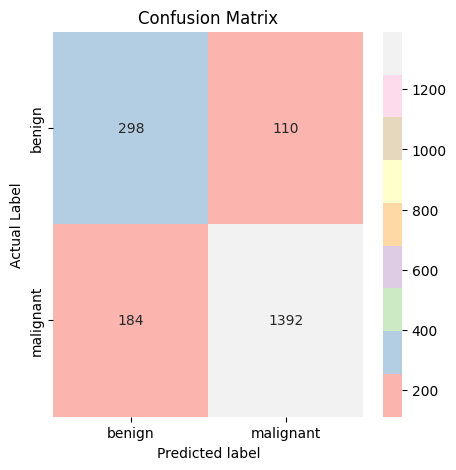

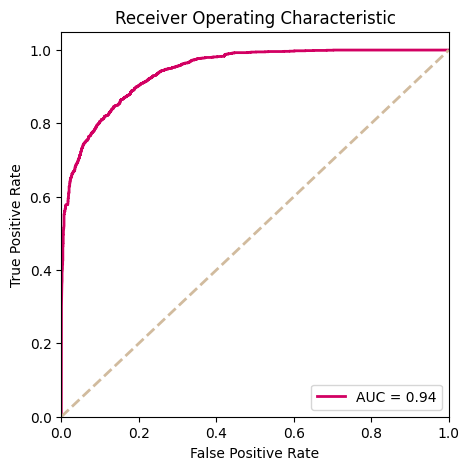

Testing the model on the test dataset
Classification Report of Test :
              precision    recall  f1-score   support

      benign     0.6016    0.4948    0.5430      1938
   malignant     0.8137    0.8707    0.8412      4910

    accuracy                         0.7643      6848
   macro avg     0.7076    0.6828    0.6921      6848
weighted avg     0.7537    0.7643    0.7568      6848

Confusion Matrix:
[[ 959  979]
 [ 635 4275]]


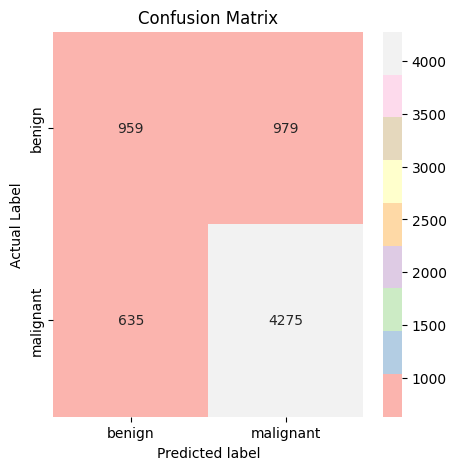

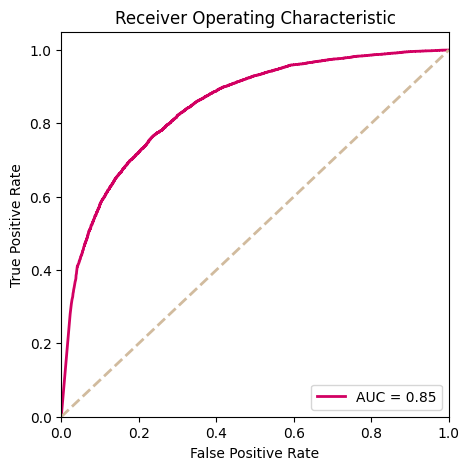

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8471

test set: Average loss: 0.0540, Accuracy: 5234/6851 (76.40%)



In [47]:
# model training
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Early stopping setup
early_stop = EarlyStopping(patience=20, verbose=True)

best_accuracy = 0
model_save_dir = './Resnet50_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

for epoch in range(1, total_epochs + 1):
    train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr, device)

    with torch.no_grad():
        val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=False)

    # Save model every 5 epochs
    if epoch % 10 == 0:
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch} to {model_save_path}')

    if val_auc > best_accuracy:
        best_accuracy = val_auc
        best_model_path = os.path.join(model_save_dir, f'{model_name}_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with AUC {best_accuracy:.4f} at epoch {epoch} to {best_model_path}')

    early_stop(val_loss, model)
    if early_stop.early_stop:
        print("Early stopping")
        # Ploting the confusion matrix and ROC curve for the final epoch
        with torch.no_grad():
            val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=True)
        break

# Evaluating the model on the test dataset
print("Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

Epoch 1/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 1 	Loss: 0.401779 	Accuracy: 81.22%


Confusion Matrix:
 [[ 302  106]
 [ 146 1430]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9529

Validation set: Average loss: 0.2727, Accuracy: 1732/1989 (87.08%)

Best model saved with AUC 0.9529 at epoch 1 to ./VGG16_Model/vgg16_best.pth
Validation loss decreased (inf --> 0.272742). save model


Epoch 2/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 2 	Loss: 0.274434 	Accuracy: 87.87%


Confusion Matrix:
 [[ 261  147]
 [ 117 1459]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9485

Validation set: Average loss: 0.3057, Accuracy: 1720/1989 (86.48%)

EarlyStopping counter: 1 out of 20


Epoch 3/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 3 	Loss: 0.212132 	Accuracy: 90.88%


Confusion Matrix:
 [[ 232  176]
 [ 100 1476]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9515

Validation set: Average loss: 0.2751, Accuracy: 1708/1989 (85.87%)

EarlyStopping counter: 2 out of 20


Epoch 4/50: 100%|██████████| 638/638 [02:42<00:00,  3.91batch/s]

Train Epoch: 4 	Loss: 0.170953 	Accuracy: 92.76%


Confusion Matrix:
 [[ 269  139]
 [ 141 1435]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9497

Validation set: Average loss: 0.3314, Accuracy: 1704/1989 (85.67%)

EarlyStopping counter: 3 out of 20


Epoch 5/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 5 	Loss: 0.143552 	Accuracy: 94.03%


Confusion Matrix:
 [[ 311   97]
 [ 218 1358]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9445

Validation set: Average loss: 0.3164, Accuracy: 1669/1989 (83.91%)

EarlyStopping counter: 4 out of 20


Epoch 6/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 6 	Loss: 0.127560 	Accuracy: 94.76%


Confusion Matrix:
 [[ 347   61]
 [ 256 1320]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9373

Validation set: Average loss: 0.3797, Accuracy: 1667/1989 (83.81%)

EarlyStopping counter: 5 out of 20


Epoch 7/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 7 	Loss: 0.113142 	Accuracy: 95.55%


Confusion Matrix:
 [[ 326   82]
 [ 243 1333]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9296

Validation set: Average loss: 0.3813, Accuracy: 1659/1989 (83.41%)

EarlyStopping counter: 6 out of 20


Epoch 8/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 8 	Loss: 0.096285 	Accuracy: 96.15%


Confusion Matrix:
 [[ 308  100]
 [ 137 1439]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9602

Validation set: Average loss: 0.2666, Accuracy: 1747/1989 (87.83%)

Best model saved with AUC 0.9602 at epoch 8 to ./VGG16_Model/vgg16_best.pth
Validation loss decreased (0.272742 --> 0.266616). save model


Epoch 9/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 9 	Loss: 0.087983 	Accuracy: 96.50%


Confusion Matrix:
 [[ 305  103]
 [ 168 1408]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9541

Validation set: Average loss: 0.3462, Accuracy: 1713/1989 (86.12%)

EarlyStopping counter: 1 out of 20


Epoch 10/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 10 	Loss: 0.079860 	Accuracy: 96.95%


Confusion Matrix:
 [[ 305  103]
 [ 180 1396]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9483

Validation set: Average loss: 0.4143, Accuracy: 1701/1989 (85.52%)

Model saved at epoch 10 to ./VGG16_Model/vgg16_epoch_10.pth
EarlyStopping counter: 2 out of 20


Epoch 11/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 11 	Loss: 0.074241 	Accuracy: 97.03%


Confusion Matrix:
 [[ 302  106]
 [ 177 1399]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9444

Validation set: Average loss: 0.3911, Accuracy: 1701/1989 (85.52%)

EarlyStopping counter: 3 out of 20


Epoch 12/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 12 	Loss: 0.070983 	Accuracy: 97.31%


Confusion Matrix:
 [[ 330   78]
 [ 172 1404]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9530

Validation set: Average loss: 0.3687, Accuracy: 1734/1989 (87.18%)

EarlyStopping counter: 4 out of 20


Epoch 13/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 13 	Loss: 0.061321 	Accuracy: 97.57%


Confusion Matrix:
 [[ 298  110]
 [ 154 1422]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9527

Validation set: Average loss: 0.3708, Accuracy: 1720/1989 (86.48%)

EarlyStopping counter: 5 out of 20


Epoch 14/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 14 	Loss: 0.054979 	Accuracy: 97.93%


Confusion Matrix:
 [[ 295  113]
 [ 175 1401]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9431

Validation set: Average loss: 0.5017, Accuracy: 1696/1989 (85.27%)

EarlyStopping counter: 6 out of 20


Epoch 15/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 15 	Loss: 0.051875 	Accuracy: 97.92%


Confusion Matrix:
 [[ 333   75]
 [ 200 1376]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9520

Validation set: Average loss: 0.4212, Accuracy: 1709/1989 (85.92%)

EarlyStopping counter: 7 out of 20


Epoch 16/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 16 	Loss: 0.047153 	Accuracy: 98.05%


Confusion Matrix:
 [[ 316   92]
 [ 204 1372]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9429

Validation set: Average loss: 0.4568, Accuracy: 1688/1989 (84.87%)

EarlyStopping counter: 8 out of 20


Epoch 17/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 17 	Loss: 0.042808 	Accuracy: 98.28%


Confusion Matrix:
 [[ 271  137]
 [ 171 1405]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9455

Validation set: Average loss: 0.4551, Accuracy: 1676/1989 (84.26%)

EarlyStopping counter: 9 out of 20


Epoch 18/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 18 	Loss: 0.044939 	Accuracy: 98.09%


Confusion Matrix:
 [[ 289  119]
 [ 143 1433]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9557

Validation set: Average loss: 0.4687, Accuracy: 1722/1989 (86.58%)

EarlyStopping counter: 10 out of 20


Epoch 19/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 19 	Loss: 0.043681 	Accuracy: 98.36%


Confusion Matrix:
 [[ 319   89]
 [ 174 1402]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9519

Validation set: Average loss: 0.4207, Accuracy: 1721/1989 (86.53%)

EarlyStopping counter: 11 out of 20


Epoch 20/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 20 	Loss: 0.035226 	Accuracy: 98.62%


Confusion Matrix:
 [[ 271  137]
 [ 132 1444]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9505

Validation set: Average loss: 0.4825, Accuracy: 1715/1989 (86.22%)

Model saved at epoch 20 to ./VGG16_Model/vgg16_epoch_20.pth
EarlyStopping counter: 12 out of 20


Epoch 21/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 21 	Loss: 0.037156 	Accuracy: 98.53%


Confusion Matrix:
 [[ 281  127]
 [ 169 1407]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9476

Validation set: Average loss: 0.5276, Accuracy: 1688/1989 (84.87%)

EarlyStopping counter: 13 out of 20


Epoch 22/50: 100%|██████████| 638/638 [02:42<00:00,  3.91batch/s]

Train Epoch: 22 	Loss: 0.032829 	Accuracy: 98.71%


Confusion Matrix:
 [[ 312   96]
 [ 160 1416]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9542

Validation set: Average loss: 0.3741, Accuracy: 1728/1989 (86.88%)

EarlyStopping counter: 14 out of 20


Epoch 23/50: 100%|██████████| 638/638 [02:42<00:00,  3.91batch/s]

Train Epoch: 23 	Loss: 0.034585 	Accuracy: 98.62%


Confusion Matrix:
 [[ 279  129]
 [ 116 1460]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9577

Validation set: Average loss: 0.4166, Accuracy: 1739/1989 (87.43%)

EarlyStopping counter: 15 out of 20


Epoch 24/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 24 	Loss: 0.030603 	Accuracy: 98.79%


Confusion Matrix:
 [[ 288  120]
 [ 131 1445]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9602

Validation set: Average loss: 0.4433, Accuracy: 1733/1989 (87.13%)

EarlyStopping counter: 16 out of 20


Epoch 25/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 25 	Loss: 0.029198 	Accuracy: 98.86%


Confusion Matrix:
 [[ 287  121]
 [ 171 1405]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9471

Validation set: Average loss: 0.5607, Accuracy: 1692/1989 (85.07%)

EarlyStopping counter: 17 out of 20


Epoch 26/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 26 	Loss: 0.027894 	Accuracy: 98.91%


Confusion Matrix:
 [[ 274  134]
 [ 167 1409]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9460

Validation set: Average loss: 0.6543, Accuracy: 1683/1989 (84.62%)

EarlyStopping counter: 18 out of 20


Epoch 27/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 27 	Loss: 0.025132 	Accuracy: 98.99%


Confusion Matrix:
 [[ 260  148]
 [  92 1484]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9570

Validation set: Average loss: 0.5139, Accuracy: 1744/1989 (87.68%)

EarlyStopping counter: 19 out of 20


Epoch 28/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 28 	Loss: 0.027155 	Accuracy: 98.94%


Confusion Matrix:
 [[ 279  129]
 [ 135 1441]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9539

Validation set: Average loss: 0.5133, Accuracy: 1720/1989 (86.48%)

EarlyStopping counter: 20 out of 20
Early stopping
Confusion Matrix:
 [[ 279  129]
 [ 135 1441]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9539

Validation set: Average loss: 0.5133, Accuracy: 1720/1989 (86.48%)

Classification Report of Validation :
               precision    recall  f1-score   support

      benign       0.67      0.68      0.68       408
   malignant       0.92      0.91      0.92      1576

    accuracy                           0.87      1984
   macro avg       0.80      0.80      0.80      1984
weighted avg       0.87      0.87      0.87      1984


Confusion Matrix of Validation :



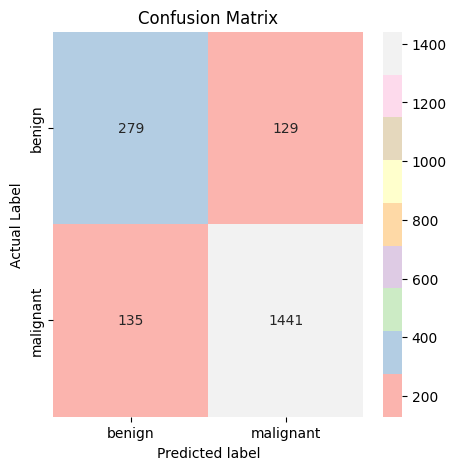

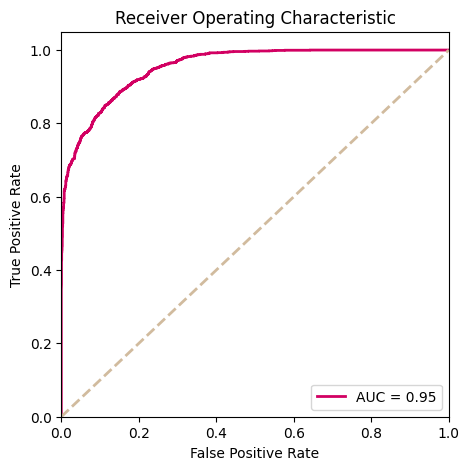

Testing the model on the test dataset
Classification Report of Test :
              precision    recall  f1-score   support

      benign     0.6681    0.4871    0.5634      1938
   malignant     0.8171    0.9045    0.8586      4910

    accuracy                         0.7864      6848
   macro avg     0.7426    0.6958    0.7110      6848
weighted avg     0.7749    0.7864    0.7750      6848

Confusion Matrix:
[[ 944  994]
 [ 469 4441]]


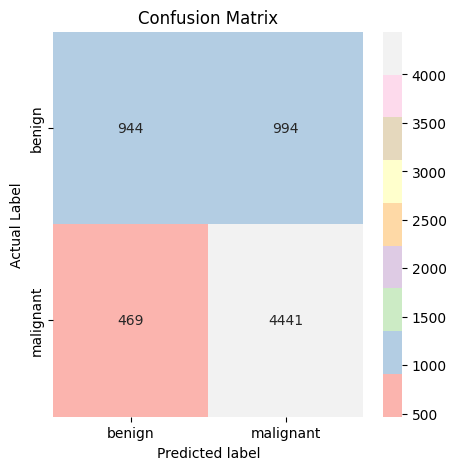

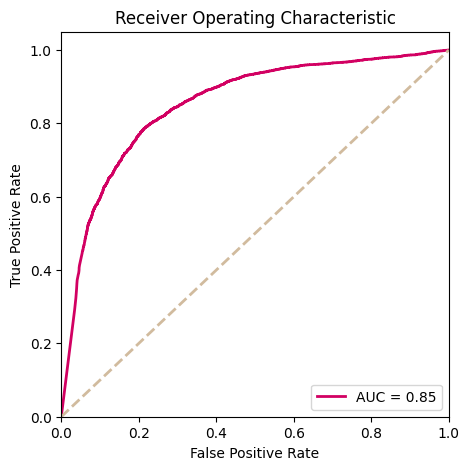

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8518

test set: Average loss: 0.0585, Accuracy: 5385/6851 (78.60%)



In [ ]:
# model training
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Early stopping setup
early_stop = EarlyStopping(patience=20, verbose=True)

best_accuracy = 0
model_save_dir = './VGG16_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

for epoch in range(1, total_epochs + 1):
    train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr, device)

    with torch.no_grad():
        val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=False)

    # Save model every 5 epochs
    if epoch % 10 == 0:
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch} to {model_save_path}')

    if val_auc > best_accuracy:
        best_accuracy = val_auc
        best_model_path = os.path.join(model_save_dir, f'{model_name}_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with AUC {best_accuracy:.4f} at epoch {epoch} to {best_model_path}')

    early_stop(val_loss, model)
    if early_stop.early_stop:
        print("Early stopping")
        # Ploting the confusion matrix and ROC curve for the final epoch
        with torch.no_grad():
            val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=True)
        break

# Evaluating the model on the test dataset
print("Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

Epoch 1/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 1 	Loss: 0.401779 	Accuracy: 81.22%


Confusion Matrix:
 [[ 302  106]
 [ 146 1430]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9529

Validation set: Average loss: 0.2727, Accuracy: 1732/1989 (87.08%)

Best model saved with AUC 0.9529 at epoch 1 to ./VGG16_Model/vgg16_best.pth
Validation loss decreased (inf --> 0.272742). save model


Epoch 2/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 2 	Loss: 0.274434 	Accuracy: 87.87%


Confusion Matrix:
 [[ 261  147]
 [ 117 1459]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9485

Validation set: Average loss: 0.3057, Accuracy: 1720/1989 (86.48%)

EarlyStopping counter: 1 out of 20


Epoch 3/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 3 	Loss: 0.212132 	Accuracy: 90.88%


Confusion Matrix:
 [[ 232  176]
 [ 100 1476]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9515

Validation set: Average loss: 0.2751, Accuracy: 1708/1989 (85.87%)

EarlyStopping counter: 2 out of 20


Epoch 4/50: 100%|██████████| 638/638 [02:42<00:00,  3.91batch/s]

Train Epoch: 4 	Loss: 0.170953 	Accuracy: 92.76%


Confusion Matrix:
 [[ 269  139]
 [ 141 1435]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9497

Validation set: Average loss: 0.3314, Accuracy: 1704/1989 (85.67%)

EarlyStopping counter: 3 out of 20


Epoch 5/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 5 	Loss: 0.143552 	Accuracy: 94.03%


Confusion Matrix:
 [[ 311   97]
 [ 218 1358]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9445

Validation set: Average loss: 0.3164, Accuracy: 1669/1989 (83.91%)

EarlyStopping counter: 4 out of 20


Epoch 6/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 6 	Loss: 0.127560 	Accuracy: 94.76%


Confusion Matrix:
 [[ 347   61]
 [ 256 1320]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9373

Validation set: Average loss: 0.3797, Accuracy: 1667/1989 (83.81%)

EarlyStopping counter: 5 out of 20


Epoch 7/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 7 	Loss: 0.113142 	Accuracy: 95.55%


Confusion Matrix:
 [[ 326   82]
 [ 243 1333]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9296

Validation set: Average loss: 0.3813, Accuracy: 1659/1989 (83.41%)

EarlyStopping counter: 6 out of 20


Epoch 8/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 8 	Loss: 0.096285 	Accuracy: 96.15%


Confusion Matrix:
 [[ 308  100]
 [ 137 1439]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9602

Validation set: Average loss: 0.2666, Accuracy: 1747/1989 (87.83%)

Best model saved with AUC 0.9602 at epoch 8 to ./VGG16_Model/vgg16_best.pth
Validation loss decreased (0.272742 --> 0.266616). save model


Epoch 9/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 9 	Loss: 0.087983 	Accuracy: 96.50%


Confusion Matrix:
 [[ 305  103]
 [ 168 1408]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9541

Validation set: Average loss: 0.3462, Accuracy: 1713/1989 (86.12%)

EarlyStopping counter: 1 out of 20


Epoch 10/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 10 	Loss: 0.079860 	Accuracy: 96.95%


Confusion Matrix:
 [[ 305  103]
 [ 180 1396]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9483

Validation set: Average loss: 0.4143, Accuracy: 1701/1989 (85.52%)

Model saved at epoch 10 to ./VGG16_Model/vgg16_epoch_10.pth
EarlyStopping counter: 2 out of 20


Epoch 11/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 11 	Loss: 0.074241 	Accuracy: 97.03%


Confusion Matrix:
 [[ 302  106]
 [ 177 1399]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9444

Validation set: Average loss: 0.3911, Accuracy: 1701/1989 (85.52%)

EarlyStopping counter: 3 out of 20


Epoch 12/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 12 	Loss: 0.070983 	Accuracy: 97.31%


Confusion Matrix:
 [[ 330   78]
 [ 172 1404]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9530

Validation set: Average loss: 0.3687, Accuracy: 1734/1989 (87.18%)

EarlyStopping counter: 4 out of 20


Epoch 13/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 13 	Loss: 0.061321 	Accuracy: 97.57%


Confusion Matrix:
 [[ 298  110]
 [ 154 1422]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9527

Validation set: Average loss: 0.3708, Accuracy: 1720/1989 (86.48%)

EarlyStopping counter: 5 out of 20


Epoch 14/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 14 	Loss: 0.054979 	Accuracy: 97.93%


Confusion Matrix:
 [[ 295  113]
 [ 175 1401]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9431

Validation set: Average loss: 0.5017, Accuracy: 1696/1989 (85.27%)

EarlyStopping counter: 6 out of 20


Epoch 15/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 15 	Loss: 0.051875 	Accuracy: 97.92%


Confusion Matrix:
 [[ 333   75]
 [ 200 1376]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9520

Validation set: Average loss: 0.4212, Accuracy: 1709/1989 (85.92%)

EarlyStopping counter: 7 out of 20


Epoch 16/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 16 	Loss: 0.047153 	Accuracy: 98.05%


Confusion Matrix:
 [[ 316   92]
 [ 204 1372]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9429

Validation set: Average loss: 0.4568, Accuracy: 1688/1989 (84.87%)

EarlyStopping counter: 8 out of 20


Epoch 17/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 17 	Loss: 0.042808 	Accuracy: 98.28%


Confusion Matrix:
 [[ 271  137]
 [ 171 1405]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9455

Validation set: Average loss: 0.4551, Accuracy: 1676/1989 (84.26%)

EarlyStopping counter: 9 out of 20


Epoch 18/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 18 	Loss: 0.044939 	Accuracy: 98.09%


Confusion Matrix:
 [[ 289  119]
 [ 143 1433]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9557

Validation set: Average loss: 0.4687, Accuracy: 1722/1989 (86.58%)

EarlyStopping counter: 10 out of 20


Epoch 19/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 19 	Loss: 0.043681 	Accuracy: 98.36%


Confusion Matrix:
 [[ 319   89]
 [ 174 1402]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9519

Validation set: Average loss: 0.4207, Accuracy: 1721/1989 (86.53%)

EarlyStopping counter: 11 out of 20


Epoch 20/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 20 	Loss: 0.035226 	Accuracy: 98.62%


Confusion Matrix:
 [[ 271  137]
 [ 132 1444]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9505

Validation set: Average loss: 0.4825, Accuracy: 1715/1989 (86.22%)

Model saved at epoch 20 to ./VGG16_Model/vgg16_epoch_20.pth
EarlyStopping counter: 12 out of 20


Epoch 21/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 21 	Loss: 0.037156 	Accuracy: 98.53%


Confusion Matrix:
 [[ 281  127]
 [ 169 1407]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9476

Validation set: Average loss: 0.5276, Accuracy: 1688/1989 (84.87%)

EarlyStopping counter: 13 out of 20


Epoch 22/50: 100%|██████████| 638/638 [02:42<00:00,  3.91batch/s]

Train Epoch: 22 	Loss: 0.032829 	Accuracy: 98.71%


Confusion Matrix:
 [[ 312   96]
 [ 160 1416]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9542

Validation set: Average loss: 0.3741, Accuracy: 1728/1989 (86.88%)

EarlyStopping counter: 14 out of 20


Epoch 23/50: 100%|██████████| 638/638 [02:42<00:00,  3.91batch/s]

Train Epoch: 23 	Loss: 0.034585 	Accuracy: 98.62%


Confusion Matrix:
 [[ 279  129]
 [ 116 1460]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9577

Validation set: Average loss: 0.4166, Accuracy: 1739/1989 (87.43%)

EarlyStopping counter: 15 out of 20


Epoch 24/50: 100%|██████████| 638/638 [02:42<00:00,  3.92batch/s]

Train Epoch: 24 	Loss: 0.030603 	Accuracy: 98.79%


Confusion Matrix:
 [[ 288  120]
 [ 131 1445]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9602

Validation set: Average loss: 0.4433, Accuracy: 1733/1989 (87.13%)

EarlyStopping counter: 16 out of 20


Epoch 25/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 25 	Loss: 0.029198 	Accuracy: 98.86%


Confusion Matrix:
 [[ 287  121]
 [ 171 1405]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9471

Validation set: Average loss: 0.5607, Accuracy: 1692/1989 (85.07%)

EarlyStopping counter: 17 out of 20


Epoch 26/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 26 	Loss: 0.027894 	Accuracy: 98.91%


Confusion Matrix:
 [[ 274  134]
 [ 167 1409]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9460

Validation set: Average loss: 0.6543, Accuracy: 1683/1989 (84.62%)

EarlyStopping counter: 18 out of 20


Epoch 27/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 27 	Loss: 0.025132 	Accuracy: 98.99%


Confusion Matrix:
 [[ 260  148]
 [  92 1484]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9570

Validation set: Average loss: 0.5139, Accuracy: 1744/1989 (87.68%)

EarlyStopping counter: 19 out of 20


Epoch 28/50: 100%|██████████| 638/638 [02:43<00:00,  3.91batch/s]

Train Epoch: 28 	Loss: 0.027155 	Accuracy: 98.94%


Confusion Matrix:
 [[ 279  129]
 [ 135 1441]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9539

Validation set: Average loss: 0.5133, Accuracy: 1720/1989 (86.48%)

EarlyStopping counter: 20 out of 20
Early stopping
Confusion Matrix:
 [[ 279  129]
 [ 135 1441]]
Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.9539

Validation set: Average loss: 0.5133, Accuracy: 1720/1989 (86.48%)

Classification Report of Validation :
               precision    recall  f1-score   support

      benign       0.67      0.68      0.68       408
   malignant       0.92      0.91      0.92      1576

    accuracy                           0.87      1984
   macro avg       0.80      0.80      0.80      1984
weighted avg       0.87      0.87      0.87      1984


Confusion Matrix of Validation :



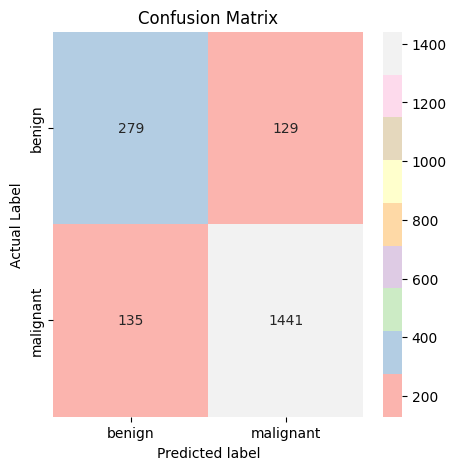

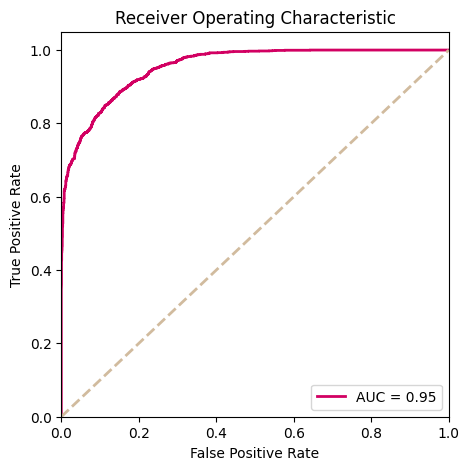

Testing the model on the test dataset
Classification Report of Test :
              precision    recall  f1-score   support

      benign     0.6681    0.4871    0.5634      1938
   malignant     0.8171    0.9045    0.8586      4910

    accuracy                         0.7864      6848
   macro avg     0.7426    0.6958    0.7110      6848
weighted avg     0.7749    0.7864    0.7750      6848

Confusion Matrix:
[[ 944  994]
 [ 469 4441]]


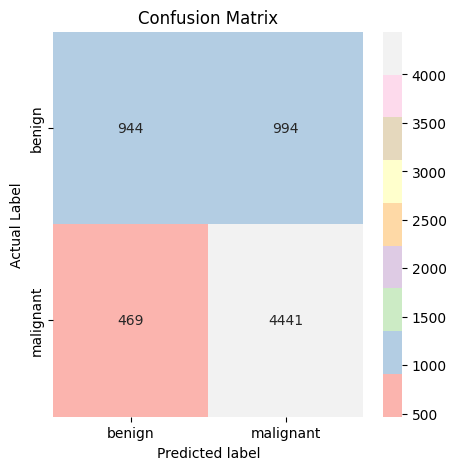

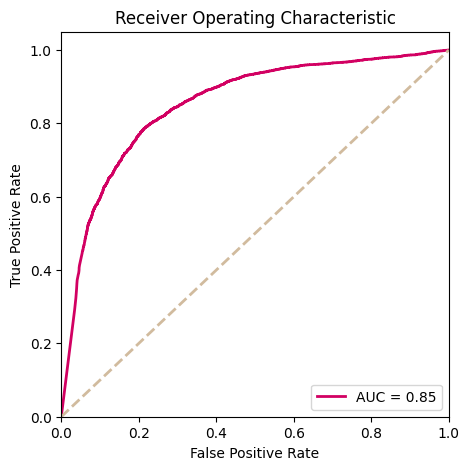

Specificity: 1.0000, Sensitivity: 0.0000, AUC: 0.8518

test set: Average loss: 0.0585, Accuracy: 5385/6851 (78.60%)



In [ ]:
# model training
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Early stopping setup
early_stop = EarlyStopping(patience=20, verbose=True)

best_accuracy = 0
model_save_dir = './VGG16_Model'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

for epoch in range(1, total_epochs + 1):
    train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr, device)

    with torch.no_grad():
        val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=False)

    # Save model every 5 epochs
    if epoch % 10 == 0:
        model_save_path = os.path.join(model_save_dir, f'{model_name}_epoch_{epoch}.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f'Model saved at epoch {epoch} to {model_save_path}')

    if val_auc > best_accuracy:
        best_accuracy = val_auc
        best_model_path = os.path.join(model_save_dir, f'{model_name}_best.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f'Best model saved with AUC {best_accuracy:.4f} at epoch {epoch} to {best_model_path}')

    early_stop(val_loss, model)
    if early_stop.early_stop:
        print("Early stopping")
        # Ploting the confusion matrix and ROC curve for the final epoch
        with torch.no_grad():
            val_accuracy, val_loss, val_auc = validation(model, val_loader, criterion, device, plot_metrics=True)
        break

# Evaluating the model on the test dataset
print("Testing the model on the test dataset")
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)